In [1]:
import numpy as np
import random
from termcolor import colored
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal

In [2]:
BOARD_ROWS = 10
BOARD_COLS = 10
WIN_STATE = (0, 9)
LOSE_STATE = (1, 9)
obstacles = [(2,0), (4,1), (1,2), (6,2), (2,4), (3,4), (4,4), (5,4), (6,4), 
             (7,4), (3,5), (9,5), (1,6), (6,6), (0,7), (6,7), (3,8), (6,8), (4,9)
            ]

In [3]:
class Environment:
    def __init__(self, BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE,
                 obstacles, DETERMINISTIC = True):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[LOSE_STATE] = -99
        self.board[WIN_STATE] = 99
        for i,j in obstacles:
            self.board[i,j] = -1
            
        while True:
            a = random.randint(0, BOARD_ROWS-1)
            b = random.randint(0, BOARD_COLS-1)
            if (a,b) not in obstacles and (a,b) != WIN_STATE and (a,b) != LOSE_STATE:
                START = (a,b)
                break    
                
        START = (9,0)        
            
        self.state = START
        self.win_state = WIN_STATE
        self.lose_state = LOSE_STATE
        self.obstacles = obstacles
        self.n_rows = BOARD_ROWS
        self.n_cols = BOARD_COLS
        self.isEnd = False
        self.determine = DETERMINISTIC
        

    def giveReward(self, obs_flag=False):
        if self.state == self.win_state:
            return 2000
        elif self.state == self.lose_state:
            return -2
        elif obs_flag == True:
            return -1
        else:
            return -0.1

    def isEndFunc(self):
        if (self.state == self.win_state) or (self.state == self.lose_state):
            self.isEnd = True

    def step(self, action):
        if self.determine:
            if action == 0: # N
                nxtState = (self.state[0] - 1, self.state[1])
            elif action == 1: # S
                nxtState = (self.state[0] + 1, self.state[1])
            elif action == 2: # W
                nxtState = (self.state[0], self.state[1] - 1)
            elif action == 3: # E
                nxtState = (self.state[0], self.state[1] + 1)
            elif action == 4: # NE
                nxtState = (self.state[0] - 1, self.state[1] + 1)
            elif action == 5: # NW
                nxtState = (self.state[0] - 1, self.state[1] - 1)
            elif action == 6: # SE
                nxtState = (self.state[0] + 1, self.state[1] + 1)
            elif action == 7: # SW
                nxtState = (self.state[0] + 1, self.state[1] - 1)    
        
            # if next state legal
            if (nxtState[0] >= 0) and (nxtState[0] <= (self.n_rows -1)):
                if (nxtState[1] >= 0) and (nxtState[1] <= (self.n_cols -1)):
                    if nxtState in self.obstacles:
                        self.isEndFunc()
                        r = self.giveReward(obs_flag=True)
                        return self.state, r, self.isEnd
                    else:
                        self.state = nxtState          
                        self.isEndFunc()
                        r = self.giveReward()
                        return self.state, r, self.isEnd
                    
            return self.state, -1, self.isEnd       
                        
    def reset(self):
        while True:
            a = random.randint(0, self.n_rows-1)
            b = random.randint(0, self.n_cols-1)
            if (a,b) not in obstacles and (a,b) != self.win_state and (a,b) != self.lose_state:
                self.state = (a,b)
                self.state = (9,0)
                self.isEnd = False
                break
        return self.state    
    
    def get_all_states(self):
        all_states = []
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                all_states.append((i,j))
                
        return all_states        
    
    def get_all_actions(self):
        all_actions = [0, 1, 2, 3, 4, 5, 6, 7]
        return all_actions

    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, self.n_rows):
            print('----------------------------------')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = colored('\033[1m' +'*', 'red')
                if self.board[i, j] == -1:
                    token = 'W'
                if self.board[i, j] == 0:
                    token = '-'
                if self.board[i, j] == -99:
                    token = 'P'    
                if self.board[i, j] == 99:
                    token = colored('\033[1m' +'G', 'green')     
                out += token + ' | '
            print(out)
        print('----------------------------------')

In [4]:
env = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [5]:
env.showBoard()

----------------------------------
| - | - | - | - | - | - | - | W | - | G | 
----------------------------------
| - | - | W | - | - | - | W | - | - | P | 
----------------------------------
| W | - | - | - | W | - | - | - | - | - | 
----------------------------------
| - | - | - | - | W | W | - | - | W | - | 
----------------------------------
| - | W | - | - | W | - | - | - | - | W | 
----------------------------------
| - | - | - | - | W | - | - | - | - | - | 
----------------------------------
| - | - | W | - | W | - | W | W | W | - | 
----------------------------------
| - | - | - | - | W | - | - | - | - | - | 
----------------------------------
| - | - | - | - | - | - | - | - | - | - | 
----------------------------------
| * | - | - | - | - | W | - | - | - | - | 
----------------------------------


# Q_learning

epsilon greedy

gamma = 0.9

In [6]:
def q_learning(env, eps, alpha, gamma, n_episodes):
    all_states = env.get_all_states()
    all_actions = env.get_all_actions()
    Q_table = np.zeros((env.n_rows, env.n_cols, len(all_actions)))
    for x,y in all_states:
        for a in all_actions:
            if (x,y) != env.win_state:
                Q_table[x,y,a] = np.random.normal()
            else:
                Q_table[x,y,a] = 0
                
    rewards_hist = []            
    for episode in range(n_episodes):
        s = env.reset()
        all_rewards = 0
        while True:
            if random.uniform(0, 1) > eps:
                a = np.argmax(Q_table[s[0], s[1], :])
            else:
                a = random.choice(all_actions)

            next_state, r, done = env.step(a)
            all_rewards += r
            
            Q_table[s[0], s[1], a] += alpha * (r + gamma * np.max(Q_table[next_state[0],next_state[1],:]) - Q_table[s[0],s[1],a])
            s = next_state
            if done:
                rewards_hist.append(all_rewards)
                print(all_rewards)
                break
                
        eps *= 0.99       
                
    return Q_table, rewards_hist             

In [109]:
_, hist = q_learning(env, 0.99, 0.1, 0.9, 1000)

-103.39999999999975
1814.300000000001
1363.5999999999885
-82.99999999999994
-50.60000000000005
1764.3000000000018
-204.09999999999843
1855.200000000001
1843.000000000001
-44.40000000000009
1839.6000000000008
1943.0
-264.59999999999843
1886.1000000000004
-182.89999999999904
1961.3
-31.50000000000004
-52.20000000000011
-134.0999999999993
1994.6
1970.3
1920.2
1989.4
1915.4
-23.300000000000015
1922.3000000000002
1952.3999999999999
1991.5
1932.3999999999999
1968.1
-26.50000000000003
1967.6
1982.2
-31.800000000000026
1924.8
1966.1
1959.8999999999999
1976.3
1992.5
1975.5
1972.9
1989.6
1985.3
1933.6
1984.3
1986.4
1978.2
1994.8
1989.0
1982.1
1974.6
1989.6
1987.5
1987.9
1990.0
1984.6
-9.799999999999994
1974.0
1991.4
1990.9
1995.4
1987.5
1994.2
1986.7
-5.9
1995.0
1995.4
1990.0
1993.4
1993.8
1996.8
1985.7
1983.3
1991.0
1989.1
1992.5
1994.6
1994.5
1996.7
1994.5
1996.1
1992.0
1995.1
1995.6
1995.3
1992.2
1992.3
1998.0
1995.6
1996.3
1997.2
1995.3
1995.5
1995.7
1994.2
1995.3
1997.5
1994.4
1993.2
1997.9

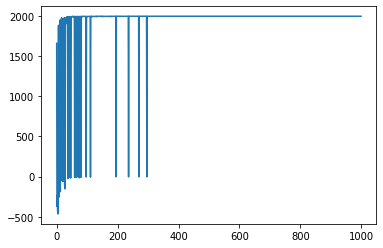

In [ ]:
plt.plot(hist)

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

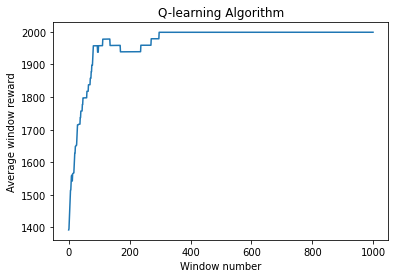

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm');

# Q_learning

epsilon greedy

gamma = 0.6


In [ ]:
_, hist = q_learning(env, 0.99, 0.1, 0.6, 1000)

1730.0000000000011
-152.79999999999916
-359.7000000000029
-93.39999999999975
-407.8000000000029
-621.8000000000121
-75.60000000000001
1942.8
1950.8999999999999
-137.09999999999928
-51.30000000000004
-141.0999999999993
-281.69999999999914
-391.90000000000435
-320.0999999999998
1928.6
1938.9999999999998
1963.3
-11.899999999999993
1882.3000000000004
1964.5
1960.2
1984.2
1949.1999999999998
1984.2
1970.0
1961.2
-16.599999999999987
1987.2
1984.2
1987.3
1912.7000000000003
1979.1
1958.8999999999999
1979.6
-28.500000000000007
1993.1
-12.699999999999996
-21.000000000000007
1962.3999999999999
1989.7
-16.69999999999999
1989.0
-9.499999999999996
-33.50000000000007
-14.199999999999992
1967.8999999999999
1987.2
1970.0
-14.699999999999985
1990.5
1980.6
-11.899999999999995
1991.8
-20.70000000000001
-13.899999999999988
1995.7
-27.70000000000001
1989.2
1996.5
1996.8
1990.2
1988.5
-10.499999999999998
1997.3
1985.8
-13.69999999999999
1989.7
1991.5
-8.199999999999998
1996.9
1988.8
-8.399999999999995
1997.1


In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

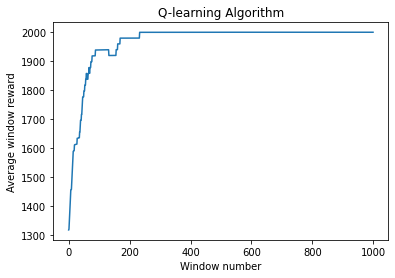

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm');

# Q_learning

epsilon greedy

gamma = 0.4

In [ ]:
_, hist = q_learning(env, 0.99, 0.1, 0.4, 600)

-826.700000000021
1894.7000000000003
-186.79999999999885
-350.1000000000015
-53.00000000000005
1915.3000000000002
1756.4000000000017
1895.4000000000003
-331.7000000000014
-63.100000000000094
-334.20000000000107
1796.300000000001
-706.6000000000166
1479.4999999999889
1427.0999999999876
-271.49999999999864
1851.400000000001
1968.7
1796.2000000000016
-43.00000000000006
1969.8
1789.600000000002
-25.90000000000002
-421.40000000000646
1889.7000000000005
1748.2000000000025
-69.90000000000015
1980.9
1978.6
1967.6
-29.90000000000004
1843.9000000000012
-86.09999999999991
1830.7000000000014
1984.6
1878.2000000000005
-159.89999999999873
1825.0000000000014
1949.3
1925.4
1950.1
1922.6000000000001
1952.3
1852.0000000000014
-24.400000000000006
1966.1999999999998
1983.2
1907.0000000000005
1915.2
1962.6
1974.5
-141.299999999999
1974.5
-42.80000000000009
-33.60000000000004
1909.6000000000001
-98.79999999999966
1975.2
1912.0000000000002
1962.8999999999999
1946.8999999999999
1960.6
1972.1999999999998
1962.

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

Text(0.5, 1.0, 'Q-learning Algorithm')

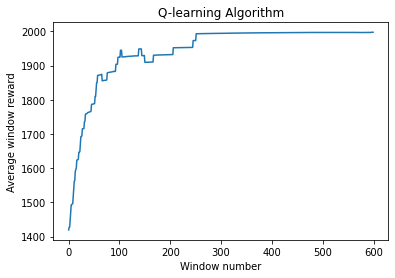

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm')

# Q_learning (slippery)

false action probability = 0.1

epsilon greedy

gamma = 0.6

In [ ]:
def q_learning(env, eps, alpha, gamma, n_episodes):
    all_states = env.get_all_states()
    all_actions = env.get_all_actions()
    Q_table = np.zeros((env.n_rows, env.n_cols, len(all_actions)))
    for x,y in all_states:
        for a in all_actions:
            if (x,y) != env.win_state:
                Q_table[x,y,a] = np.random.normal()
            else:
                Q_table[x,y,a] = 0
                
    rewards_hist = []            
    for episode in range(n_episodes):
        s = env.reset()
        all_rewards = 0
        while True:
            if random.uniform(0, 1) > eps:
                a = np.argmax(Q_table[s[0], s[1], :])
                if random.uniform(0,1) > 0.9:
                    a = random.choice(all_actions)      
            else:
                a = random.choice(all_actions)

            next_state, r, done = env.step(a)
            all_rewards += r
            
            Q_table[s[0], s[1], a] += alpha * (r + gamma * np.max(Q_table[next_state[0],next_state[1],:]) - Q_table[s[0],s[1],a])
            s = next_state
            if done:
                rewards_hist.append(all_rewards)
                print(all_rewards)
                break
                
        eps *= 0.99       
                
    return Q_table, rewards_hist             

In [ ]:
_, hist = q_learning(env, 0.99, 0.1, 0.6, 600)

-486.1000000000048
-230.69999999999848
1861.0000000000007
-87.1999999999999
-56.80000000000008
-145.8999999999991
-94.09999999999992
-99.39999999999988
-130.3999999999994
-105.09999999999974
-206.4999999999983
-178.39999999999839
-43.30000000000005
1805.5000000000018
-265.89999999999816
1919.7000000000003
-78.30000000000004
1963.0
-78.69999999999996
-224.99999999999838
1975.3
1910.4000000000003
1981.1
-61.10000000000011
-85.19999999999987
1969.8
1967.8
-134.7999999999994
1966.8
1937.0
1927.8999999999999
-69.80000000000007
1938.2999999999997
-12.399999999999995
1980.6
1976.5
-35.20000000000006
-17.399999999999984
1990.1
1984.9
1976.1
-54.800000000000075
1980.0
1979.9
-10.899999999999999
1995.5
1960.0
-19.199999999999992
1959.6
1988.3
1979.6
1975.1
-8.799999999999994
-9.399999999999993
1968.6
1982.6
1988.8
1993.6
1980.3
1995.7
1987.2
1968.0
-17.39999999999999
1993.4
1971.7
1983.6
1980.8
1979.0
-16.999999999999982
1991.2
1984.1
-5.000000000000001
1983.9
1982.4
1995.7
-11.299999999999994
-

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

Text(0.5, 1.0, 'Q-learning Algorithm')

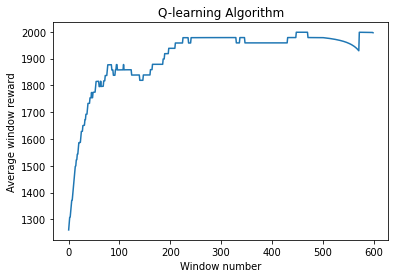

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm')

# Q_learning (slippery)

false action probability = 0.4

epsilon greedy

gamma = 0.6

In [ ]:
def q_learning(env, eps, alpha, gamma, n_episodes):
    all_states = env.get_all_states()
    all_actions = env.get_all_actions()
    Q_table = np.zeros((env.n_rows, env.n_cols, len(all_actions)))
    for x,y in all_states:
        for a in all_actions:
            if (x,y) != env.win_state:
                Q_table[x,y,a] = np.random.normal()
            else:
                Q_table[x,y,a] = 0
                
    rewards_hist = []            
    for episode in range(n_episodes):
        s = env.reset()
        all_rewards = 0
        while True:
            if random.uniform(0, 1) > eps:
                a = np.argmax(Q_table[s[0], s[1], :])
                if random.uniform(0,1) > 0.6:
                    a = random.choice(all_actions)      
            else:
                a = random.choice(all_actions)

            next_state, r, done = env.step(a)
            all_rewards += r
            
            Q_table[s[0], s[1], a] += alpha * (r + gamma * np.max(Q_table[next_state[0],next_state[1],:]) - Q_table[s[0],s[1],a])
            s = next_state
            if done:
                rewards_hist.append(all_rewards)
                print(all_rewards)
                break
                
        eps *= 0.99       
                
    return Q_table, rewards_hist             

In [ ]:
_, hist = q_learning(env, 0.99, 0.1, 0.6, 600)

1906.1000000000001
1422.3999999999912
-262.99999999999875
-123.89999999999942
-403.8000000000054
1989.4
1954.3
1858.6000000000008
1912.0
-96.09999999999981
-120.69999999999946
-29.30000000000002
-57.000000000000085
-271.0999999999988
1857.6000000000006
1876.2000000000007
-122.19999999999943
1812.1000000000013
-92.09999999999991
1955.6
-85.09999999999988
-25.70000000000001
1974.0
1870.9000000000005
1983.3
-69.80000000000005
-47.300000000000054
-39.50000000000005
1969.5
1946.6
1962.2
1979.2
1933.9999999999998
-115.19999999999928
-44.800000000000054
-56.2000000000001
-42.80000000000006
1977.5
-19.299999999999994
1983.4
-13.69999999999999
1969.6
1969.8999999999999
1958.1
-33.30000000000002
-31.90000000000002
1950.8999999999999
1944.3
1960.6
-53.70000000000012
1959.1999999999998
1987.0
1954.0
1968.8999999999999
1985.6
-23.000000000000007
1995.3
1980.8
1938.3999999999999
1982.1
1971.6
1988.2
1987.9
1966.8
-8.999999999999995
1978.4
-9.199999999999998
1980.0
1983.8
1992.6
1986.6
-10.7999999999

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

Text(0.5, 1.0, 'Q-learning Algorithm')

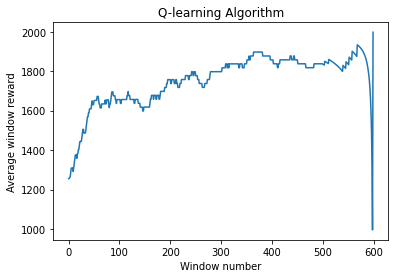

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm')

# Q_learning (slippery)

false action probability = 0.7

epsilon greedy

gamma = 0.6

In [ ]:
def q_learning(env, eps, alpha, gamma, n_episodes):
    all_states = env.get_all_states()
    all_actions = env.get_all_actions()
    Q_table = np.zeros((env.n_rows, env.n_cols, len(all_actions)))
    for x,y in all_states:
        for a in all_actions:
            if (x,y) != env.win_state:
                Q_table[x,y,a] = np.random.normal()
            else:
                Q_table[x,y,a] = 0
                
    rewards_hist = []            
    for episode in range(n_episodes):
        s = env.reset()
        all_rewards = 0
        while True:
            if random.uniform(0, 1) > eps:
                a = np.argmax(Q_table[s[0], s[1], :])
                if random.uniform(0,1) > 0.3:
                    a = random.choice(all_actions)      
            else:
                a = random.choice(all_actions)

            next_state, r, done = env.step(a)
            all_rewards += r
            
            Q_table[s[0], s[1], a] += alpha * (r + gamma * np.max(Q_table[next_state[0],next_state[1],:]) - Q_table[s[0],s[1],a])
            s = next_state
            if done:
                rewards_hist.append(all_rewards)
                print(all_rewards)
                break
                
        eps *= 0.99       
                
    return Q_table, rewards_hist             

In [ ]:
_, hist = q_learning(env, 0.99, 0.1, 0.6, 600)

-240.89999999999833
-297.4
-14.799999999999992
-26.50000000000002
-301.8000000000001
1936.6
-234.39999999999858
1781.6000000000015
-204.89999999999867
-279.9999999999992
-230.8999999999985
-130.49999999999943
-68.2000000000001
1844.3000000000009
-333.9000000000018
-123.89999999999966
-98.99999999999969
1915.1000000000001
-102.9999999999998
1662.8999999999985
1938.5
1934.6
1978.6
-586.0000000000118
1665.0999999999995
-42.40000000000004
1955.8999999999999
-122.49999999999949
-118.79999999999961
-154.59999999999934
-97.89999999999961
1749.600000000002
-43.70000000000009
-162.59999999999908
1965.2
-31.400000000000013
-29.90000000000005
-56.100000000000094
-79.40000000000003
-35.000000000000014
1924.1999999999998
1935.8999999999999
1956.3
-241.69999999999837
-49.40000000000012
-26.700000000000028
1903.5000000000002
1843.2000000000007
1956.3
-69.00000000000006
-22.40000000000001
1975.3999999999999
-35.60000000000005
-22.8
-69.40000000000006
1889.8000000000004
-26.100000000000033
-30.40000000

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

Text(0.5, 1.0, 'Q-learning Algorithm')

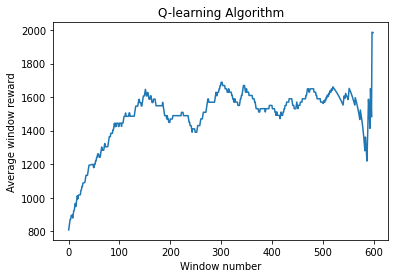

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm')

# Q_learning

epsilon greedy

alpha = 0.5

In [ ]:
_, hist = q_learning(env, 0.99, 0.5, 0.9, 1000)

-420.00000000000404
-94.39999999999984
-198.99999999999895
-124.29999999999956
-30.500000000000032
1950.2
1883.7000000000003
1847.0000000000011
-320.30000000000075
-265.4999999999984
1969.5
1970.2
-105.8999999999997
1951.8
1798.5000000000016
1963.5
1986.2
-99.49999999999983
-39.60000000000007
1969.5
1985.3
-30.000000000000014
-14.599999999999994
1970.6
-43.300000000000026
1978.4
1979.2
1986.4
1992.0
1982.4
-18.099999999999984
1990.3
1989.8
1979.1
1991.9
1988.8
1982.0
1985.8
-14.19999999999999
-24.600000000000026
1994.3
1991.5
1994.6
1991.0
1978.9
-21.900000000000006
1988.1
-6.9
-11.699999999999994
1986.0
1991.0
1991.1
1989.3
1989.4
1988.2
1991.6
1986.1
1995.4
1992.6
1992.8
1993.2
1996.2
1991.7
1997.1
1989.8
1991.9
1996.9
1994.1
1991.7
1981.9
1995.2
1996.8
1997.4
1993.3
1989.2
1996.5
1992.3
1995.8
1988.4
1993.4
-6.699999999999999
1993.2
1994.3
1993.8
1995.5
1994.8
-3.8000000000000007
1994.3
1994.4
1995.9
1996.3
-5.900000000000002
1997.9
1996.2
1994.1
1996.7
1995.8
1997.1
1997.3
1995.2
1

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

Text(0.5, 1.0, 'Q-learning Algorithm')

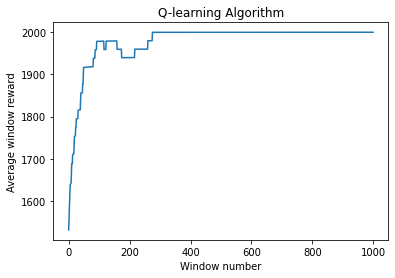

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm')

# Q_learning

epsilon greedy

alpha = 0.9

In [ ]:
_, hist = q_learning(env, 0.99, 0.9, 0.9, 1000)

-267.5999999999989
1925.1
-245.89999999999836
-232.49999999999847
-37.50000000000004
1964.5
1960.3
-122.99999999999957
-187.5999999999989
1918.1000000000001
-41.30000000000005
1972.4
1955.6
1948.3999999999999
1964.2
-44.20000000000013
-41.20000000000007
1986.7
1948.3
-15.19999999999999
-37.70000000000004
-11.799999999999994
-41.400000000000055
1985.1
1986.3
1985.6
-23.800000000000004
1980.6
-35.00000000000005
1990.5
1993.8
1984.9
1985.7
-12.499999999999995
1982.0
1983.9
1988.9
1989.1
1989.6
1987.5
-9.299999999999997
1994.3
-17.499999999999986
1990.4
1984.2
1990.0
1994.4
1984.9
1993.1
1980.0
1992.0
-10.899999999999995
-10.899999999999995
1990.7
1989.5
1993.9
1990.7
1981.8
1990.4
1991.0
1989.4
1995.7
1992.8
1993.4
1995.0
1997.8
1995.2
-11.299999999999995
-10.199999999999996
-6.400000000000001
1995.6
1990.2
1993.2
1994.1
1994.5
1991.6
1996.2
1994.3
1994.8
1996.6
1988.8
1996.4
1996.6
1992.4
1997.7
1996.2
1997.7
1995.6
1997.1
1995.2
1997.9
1995.5
1995.8
1998.0
1995.2
1994.7
1995.2
1992.3
19

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

Text(0.5, 1.0, 'Q-learning Algorithm')

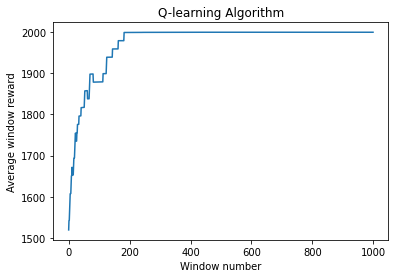

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm')

# Q_learning

epsilon greedy

first_epsilon = 0.6

In [ ]:
_, hist = q_learning(env, 0.6, 0.1, 0.9, 1000)

-258.8999999999975
1935.6
-182.09999999999818
1894.5000000000005
1864.4000000000008
-31.900000000000063
1914.4
1978.9
-115.49999999999939
1686.7000000000003
1967.6
-49.50000000000016
1973.3999999999999
1947.2999999999997
1958.5
1887.8000000000009
1861.2000000000014
-53.500000000000135
1982.9
1950.9999999999998
1974.5
1990.5
-34.70000000000003
1988.3
1978.9
1986.7
1918.5
1997.8
1987.8
1910.9000000000003
1966.6999999999998
1983.8
1980.4
1992.0
1942.1
1997.1
1986.8
1993.2
1995.1
1989.1
1996.0
1990.0
1994.5
1997.1
1991.4
1997.0
1997.6
1995.0
1996.2
1993.8
1996.5
1996.4
1998.5
1997.5
1995.0
-7.199999999999999
1994.4
1996.3
1997.7
1997.0
1994.7
1996.2
1990.6
1995.5
1996.8
1998.5
1996.6
1995.2
1996.6
1996.4
1998.0
1995.3
1993.8
1995.9
1995.0
1996.9
1993.7
1995.7
-6.300000000000001
1996.4
1997.5
1995.3
1998.0
1996.2
1997.6
1995.4
1997.6
1994.0
1998.4
1997.7
1997.4
1997.7
1998.5
1998.3
1998.5
1997.5
1998.7
1997.3
1998.7
1996.3
1995.7
1996.5
1998.5
1998.7
1994.2
1997.6
1991.9
1996.3
1996.4
1998.

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

Text(0.5, 1.0, 'Q-learning Algorithm')

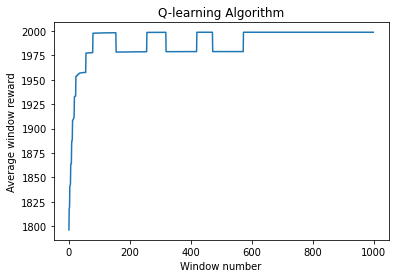

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm')

# Q_learning

epsilon greedy

first_epsilon = 0.3

In [ ]:
_, hist = q_learning(env, 0.3, 0.1, 0.9, 1000)

-261.6999999999978
-215.49999999999739
-475.7000000000181
-77.60000000000002
-11.39999999999999
-139.19999999999905
1991.7
1987.8
-38.40000000000014
1948.0999999999997
1990.7
-82.09999999999991
1959.6999999999998
1947.4999999999998
1926.3
1967.3
-41.700000000000045
1980.0
1954.3999999999996
1908.8999999999999
1974.2
1988.8
1954.7999999999997
1994.0
1975.8999999999999
1983.2
1984.3
1986.2
1985.0
1978.3
1974.8
1989.1
-28.300000000000068
1971.0
1970.3
1991.0
1996.7
1990.9
1990.8
-21.199999999999996
1987.3
1983.4
1983.6
1995.1
1993.1
1997.5
1994.9
1994.7
1984.9
1995.2
1993.5
1995.6
1993.8
1993.0
1995.9
1995.8
1997.6
1995.7
1990.8
1994.3
1993.3
1995.9
1996.2
1995.6
1997.2
1996.5
1994.5
1998.0
1996.7
1995.3
1994.3
1996.2
1998.2
1996.7
1995.8
1995.6
1998.3
1997.1
1995.7
1996.3
1997.6
1997.5
1996.9
1998.5
1993.5
1998.7
1998.5
1998.6
1995.2
1998.6
1998.2
1998.7
1998.4
1998.7
1997.2
1998.7
1997.5
1998.7
1998.4
1996.5
1998.7
1998.7
1997.7
1998.1
1996.7
1997.5
1996.5
1998.8
1998.4
1998.7
1998.8
19

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

Text(0.5, 1.0, 'Q-learning Algorithm')

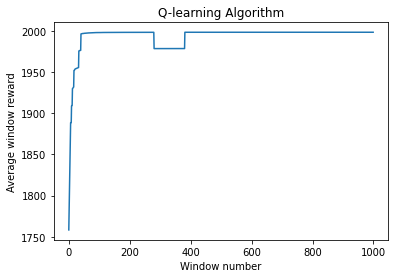

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm')

# Q_learning

epsilon greedy

first_epsilon = 0.1

In [ ]:
_, hist = q_learning(env, 0.1, 0.1, 0.9, 1000)

-181.69999999999854
-398.20000000000766
-52.20000000000016
-38.60000000000016
-34.30000000000006
1989.6
1993.2
1990.1
1989.1
1994.2
1988.3
1991.9
1990.6
1986.5
1993.8
1991.8
1987.4
1994.8
1991.5
1998.1
1998.5
1995.7
1994.8
-10.399999999999991
-7.399999999999996
1997.5
1996.2
1997.1
1981.1
1996.6
1997.1
1997.2
1996.9
1998.4
1992.0
1987.2
1997.2
1995.6
1998.6
1996.5
1997.4
1997.8
1997.4
1937.8999999999999
1997.8
1998.4
1998.3
1984.4
1989.5
1993.2
1994.0
1998.0
1996.1
1995.8
1997.5
1998.6
1960.6999999999998
1998.2
1997.7
1998.3
1998.5
1998.6
1998.6
1998.4
1998.6
1997.2
1998.6
1997.6
1998.6
1998.3
1998.6
1998.6
1998.6
1998.6
1997.6
1998.6
1998.6
1998.6
1998.6
1998.6
1998.6
1998.6
1998.6
1996.6
1998.6
1998.6
1998.6
1998.6
1998.6
1995.4
1997.4
1997.6
1998.6
1998.6
1998.6
1998.6
1998.6
1998.6
1998.6
1997.6
1998.6
1998.6
1998.4
1998.6
1998.6
1998.6
1998.6
1998.6
1994.9
1998.4
1998.6
1998.6
1998.6
1998.6
1997.6
1997.6
1998.3
1998.6
1998.2
1998.6
1998.2
1998.6
1998.6
1998.6
1998.6
1998.6
1997.6


In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

Text(0.5, 1.0, 'Q-learning Algorithm')

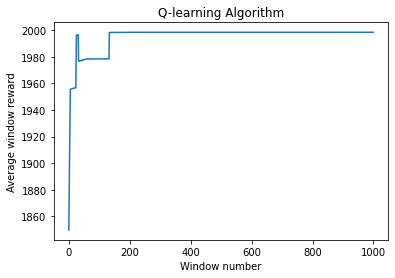

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Q-learning Algorithm')

## Actor-critic

In [48]:
def action_map(a):
    if a == 0:
        return (0,1)
    if a == 1:
        return (0,-1)
    if a == 2:
        return (-1,0)
    if a == 3:
        return (1,0)
    if a == 4:
        return (1,1)
    if a == 5:
        return (-1,1)
    if a == 6:
        return (1,-1)
    if a == 7:
        return (-1,-1)

In [ ]:
def policy(func_approx, s, all_actions, theta):
    nums = []
    for a in all_actions:
        a_code = action_map(a)
        coding = np.zeros((len(func_approx), 1))
        ind = 0
        for func in func_approx:
            coding[ind,0] = func.pdf([s[0],s[1],a_code[0],a_code[1]])
            ind += 1 
            
        nums.append(np.exp(coding.T @ theta))
        
    policy_prob = []
    for num in nums:
        policy_prob.append(float(num / sum(nums)))
#     print(policy_prob)    
    return policy_prob   

In [ ]:
def compute_Q(func_approx, s, a, w):
    a_code = action_map(a)
    coding = np.zeros((len(func_approx), 1))
    ind = 0
    for func in func_approx:
        coding[ind,0] = func.pdf([s[0],s[1],a_code[0],a_code[1]])
        ind += 1 
        
    return coding.T @ w, coding  

In [ ]:
def policy_derivative(func_approx, s, a, all_actions, theta):
    a_code = action_map(a)
    phi_s_ai = np.zeros((len(func_approx), 1))
    ind = 0
    for func in func_approx:
        phi_s_ai[ind, 0] = func.pdf([s[0],s[1],a_code[0],a_code[1]])
        ind += 1
        
    all_phis = []
    for action in all_actions:
        a_code = action_map(action)
        temp = np.zeros((len(func_approx), 1))
        ind = 0
        for func in func_approx: 
            temp[ind, 0] = func.pdf([s[0],s[1],a_code[0],a_code[1]])
            ind += 1
        all_phis.append(temp)    
        
    num = np.zeros((len(func_approx), 1))
    den = 0
    for phi in all_phis:
        num += phi * np.exp(phi.T @ theta)
        den += np.exp(phi.T @ theta)
        
    return phi_s_ai - num / den  

In [ ]:
def actor_critc(env, n_components, mu, sigma, alpha, beta, gamma, n_episodes):
    func_approx = []
    for i in range(n_components):
        func_approx.append(multivariate_normal(mean=mu[i], cov=sigma[i]))
        
    mean = np.zeros(n_components)
    cov = np.eye(n_components)
    w = np.random.multivariate_normal(mean, cov)
    theta = np.random.multivariate_normal(mean, cov)
    #theta = 0.0001
    rewards_hist = [] 
    
    for episode in range(n_episodes):
        s = env.reset()
        all_actions = env.get_all_actions()
        a = int(np.random.choice(all_actions, p=policy(func_approx, s, all_actions, theta)))
        all_rewards = 0
        steps = 0
        while True:
            s_prime, r, done = env.step(a)
            all_rewards += r
            
            a_prime = int(np.random.choice(all_actions, p=policy(func_approx, s_prime, all_actions, theta)))
            Q, phi_s_a = compute_Q(func_approx, s, a, w)
            Q_prime, _ = compute_Q(func_approx, s_prime, a_prime, w)
            delta = r + gamma * Q_prime - Q
            if s_prime == env.win_state:
                print('Congrat')
                print(episode)

            theta += alpha * policy_derivative(func_approx, s, a, all_actions, theta) @ Q

            w += beta * phi_s_a @ delta
            a = a_prime
            steps += 1
            s = s_prime
            if done or steps >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
    return func_approx, theta, rewards_hist            

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.1, 0.1, 0.9, 1000)

Congrat
3
Congrat
8
Congrat
19
Congrat
23
Congrat
24
Congrat
46
Congrat
49
Congrat
53
Congrat
59
Congrat
73
Congrat
75
Congrat
93
Congrat
95
Congrat
96
Congrat
101
Congrat
111
Congrat
127
Congrat
132
Congrat
134
Congrat
145
Congrat
149
Congrat
154
Congrat
160
Congrat
161
Congrat
183
Congrat
199
Congrat
201
Congrat
208
Congrat
211
Congrat
216
Congrat
233
Congrat
237
Congrat
239
Congrat
244
Congrat
246
Congrat
250
Congrat
253
Congrat
260
Congrat
263
Congrat
271
Congrat
272
Congrat
291
Congrat
298
Congrat
317
Congrat
328
Congrat
335
Congrat
344
Congrat
356
Congrat
357
Congrat
361
Congrat
369
Congrat
370
Congrat
376
Congrat
387
Congrat
395
Congrat
409
Congrat
411
Congrat
421
Congrat
439
Congrat
445
Congrat
446
Congrat
467
Congrat
488
Congrat
496
Congrat
498
Congrat
512
Congrat
527
Congrat
530
Congrat
552
Congrat
557
Congrat
560
Congrat
570
Congrat
575
Congrat
581
Congrat
594
Congrat
613
Congrat
627
Congrat
629
Congrat
635
Congrat
636
Congrat
640
Congrat
668
Congrat
676
Congrat
683
Congrat


In [ ]:
max(rewards_hist)

1982.5

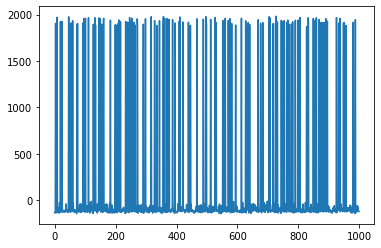

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

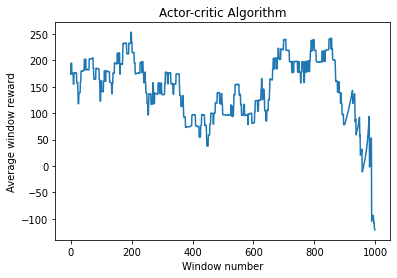

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

In [ ]:
mu = [np.array([3,4,0.5,0.5]), np.array([7,4,-0.5,-0.5])]
      
sigma = [np.eye(4), np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 2, mu, sigma, 0.1, 0.1, 0.9, 1000)

Congrat
4
Congrat
15
Congrat
24
Congrat
31
Congrat
33
Congrat
38
Congrat
51
Congrat
57
Congrat
58
Congrat
65
Congrat
66
Congrat
79
Congrat
83
Congrat
96
Congrat
104
Congrat
108
Congrat
123
Congrat
163
Congrat
177
Congrat
179
Congrat
183
Congrat
186
Congrat
195
Congrat
197
Congrat
222
Congrat
243
Congrat
251
Congrat
263
Congrat
264
Congrat
304
Congrat
314
Congrat
334
Congrat
339
Congrat
341
Congrat
357
Congrat
360
Congrat
366
Congrat
372
Congrat
373
Congrat
385
Congrat
386
Congrat
390
Congrat
396
Congrat
400
Congrat
405
Congrat
411
Congrat
425
Congrat
431
Congrat
444
Congrat
453
Congrat
460
Congrat
464
Congrat
466
Congrat
492
Congrat
532
Congrat
547
Congrat
557
Congrat
574
Congrat
581
Congrat
582
Congrat
595
Congrat
598
Congrat
599
Congrat
613
Congrat
614
Congrat
624
Congrat
630
Congrat
634
Congrat
648
Congrat
649
Congrat
659
Congrat
664
Congrat
674
Congrat
692
Congrat
694
Congrat
703
Congrat
711
Congrat
713
Congrat
717
Congrat
721
Congrat
727
Congrat
729
Congrat
746
Congrat
752
Congrat

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

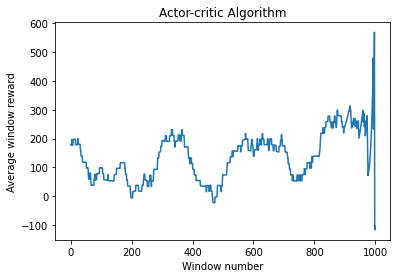

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Actor critic

beta = 0.5

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.1, 0.5, 0.9, 1000)

Congrat
3
Congrat
6
Congrat
8
Congrat
12
Congrat
20
Congrat
35
Congrat
38
Congrat
40
Congrat
46
Congrat
49
Congrat
57
Congrat
61
Congrat
73
Congrat
84
Congrat
85
Congrat
101
Congrat
114
Congrat
116
Congrat
134
Congrat
143
Congrat
157
Congrat
173
Congrat
179
Congrat
181
Congrat
197
Congrat
218
Congrat
236
Congrat
263
Congrat
268
Congrat
269
Congrat
272
Congrat
275
Congrat
295
Congrat
302
Congrat
314
Congrat
330
Congrat
331
Congrat
340
Congrat
355
Congrat
365
Congrat
366
Congrat
369
Congrat
372
Congrat
394
Congrat
399
Congrat
401
Congrat
406
Congrat
412
Congrat
419
Congrat
434
Congrat
454
Congrat
458
Congrat
483
Congrat
492
Congrat
497
Congrat
499
Congrat
504
Congrat
512
Congrat
516
Congrat
522
Congrat
531
Congrat
549
Congrat
556
Congrat
570
Congrat
573
Congrat
578
Congrat
581
Congrat
583
Congrat
597
Congrat
599
Congrat
623
Congrat
627
Congrat
629
Congrat
637
Congrat
647
Congrat
655
Congrat
665
Congrat
669
Congrat
676
Congrat
690
Congrat
716
Congrat
724
Congrat
735
Congrat
746
Congrat
75

In [ ]:
max(rewards_hist)

1983.3

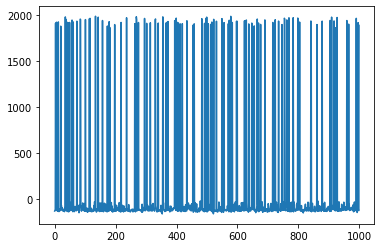

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

average is: 112.12139237332225


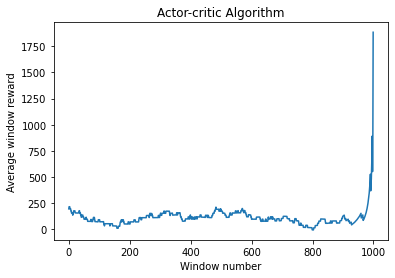

In [ ]:
print("average is:", np.average(window))
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Actor critic

beta = 0.9

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.1, 0.9, 0.9, 1000)

Congrat
0
Congrat
1
Congrat
3
Congrat
7
Congrat
12
Congrat
14
Congrat
34
Congrat
39
Congrat
41
Congrat
42
Congrat
43
Congrat
55
Congrat
56
Congrat
66
Congrat
71
Congrat
93
Congrat
94
Congrat
95
Congrat
96
Congrat
99
Congrat
101
Congrat
107
Congrat
111
Congrat
133
Congrat
137
Congrat
194
Congrat
197
Congrat
204
Congrat
214
Congrat
220
Congrat
223
Congrat
229
Congrat
245
Congrat
259
Congrat
260
Congrat
267
Congrat
281
Congrat
293
Congrat
301
Congrat
302
Congrat
316
Congrat
317
Congrat
338
Congrat
351
Congrat
364
Congrat
369
Congrat
378
Congrat
379
Congrat
381
Congrat
393
Congrat
396
Congrat
397
Congrat
398
Congrat
400
Congrat
418
Congrat
431
Congrat
434
Congrat
462
Congrat
474
Congrat
478
Congrat
485
Congrat
492
Congrat
508
Congrat
539
Congrat
548
Congrat
551
Congrat
585
Congrat
601
Congrat
608
Congrat
609
Congrat
616
Congrat
623
Congrat
630
Congrat
637
Congrat
642
Congrat
648
Congrat
652
Congrat
663
Congrat
676
Congrat
714
Congrat
723
Congrat
740
Congrat
745
Congrat
751
Congrat
774
Cong

In [ ]:
max(rewards_hist)

1989.4

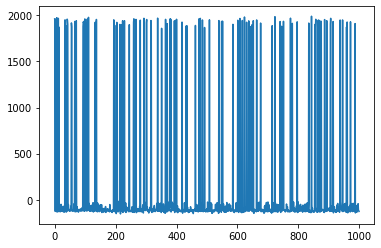

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

average is: 97.24604332727904


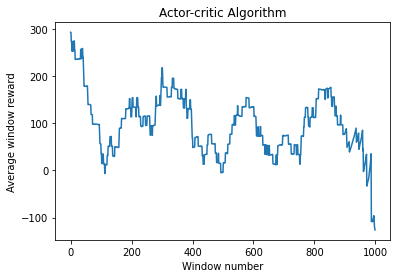

In [ ]:
print("average is:", np.average(window))
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Actor critic

beta = 10

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.1, 10, 0.9, 1000)

Congrat
8
Congrat
24
Congrat
27
Congrat
29
Congrat
32
Congrat
37
Congrat
75
Congrat
81
Congrat
90
Congrat
94
Congrat
102
Congrat
105
Congrat
109
Congrat
111
Congrat
112
Congrat
123
Congrat
125
Congrat
137
Congrat
138
Congrat
143
Congrat
180
Congrat
181
Congrat
184
Congrat
204
Congrat
205
Congrat
206
Congrat
213
Congrat
218
Congrat
222
Congrat
227
Congrat
228
Congrat
234
Congrat
278
Congrat
280
Congrat
283
Congrat
314
Congrat
327
Congrat
330
Congrat
336
Congrat
339
Congrat
351
Congrat
361
Congrat
366
Congrat
373
Congrat
379
Congrat
386
Congrat
408
Congrat
419
Congrat
428
Congrat
431
Congrat
450
Congrat
456
Congrat
460
Congrat
461
Congrat
485
Congrat
486
Congrat
493
Congrat
512
Congrat
519
Congrat
524
Congrat
527
Congrat
536
Congrat
541
Congrat
542
Congrat
551
Congrat
561
Congrat
567
Congrat
568
Congrat
575
Congrat
580
Congrat
585
Congrat
594
Congrat
600
Congrat
603
Congrat
625
Congrat
626
Congrat
629
Congrat
633
Congrat
651
Congrat
659
Congrat
665
Congrat
688
Congrat
689
Congrat
703
Con

In [ ]:
max(rewards_hist)

1988.7

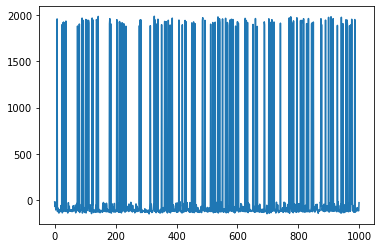

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

average is: 151.85316741584265


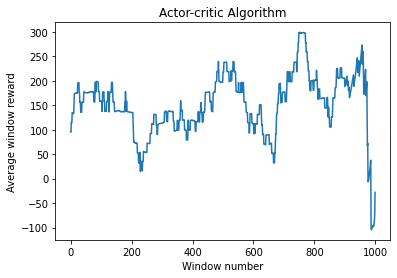

In [ ]:
print("average is:", np.average(window))
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Actor critic

beta = 100

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.5, 20, 0.9, 1000)

Congrat
11
Congrat
25
Congrat
51
Congrat
64
Congrat
97
Congrat
101
Congrat
103
Congrat
106
Congrat
118
Congrat
160
Congrat
164
Congrat
186
Congrat
191
Congrat
206
Congrat
217
Congrat
232
Congrat
234
Congrat
239
Congrat
244
Congrat
255
Congrat
269
Congrat
282
Congrat
290
Congrat
295
Congrat
300
Congrat
301
Congrat
302
Congrat
309
Congrat
312
Congrat
329
Congrat
347
Congrat
354
Congrat
362
Congrat
370
Congrat
376
Congrat
377
Congrat
386
Congrat
398
Congrat
403
Congrat
406
Congrat
413
Congrat
446
Congrat
468
Congrat
470
Congrat
503
Congrat
505
Congrat
523
Congrat
538
Congrat
552
Congrat
554
Congrat
577
Congrat
578
Congrat
584
Congrat
586
Congrat
606
Congrat
608
Congrat
638
Congrat
641
Congrat
643
Congrat
647
Congrat
654
Congrat
655
Congrat
660
Congrat
662
Congrat
682
Congrat
683
Congrat
687
Congrat
688
Congrat
704
Congrat
705
Congrat
714
Congrat
718
Congrat
727
Congrat
729
Congrat
738
Congrat
752
Congrat
759
Congrat
766
Congrat
788
Congrat
798
Congrat
802
Congrat
828
Congrat
832
Congrat
8

In [ ]:
max(rewards_hist)

1980.7

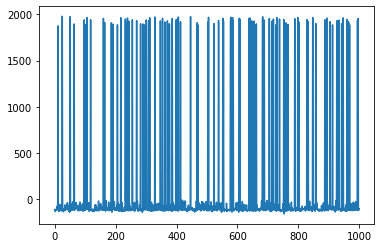

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

average is: 109.55523324199136


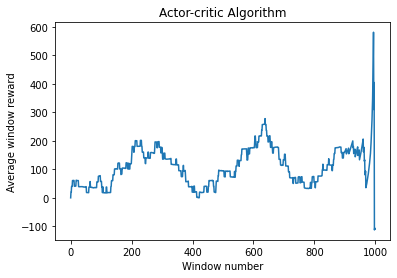

In [ ]:
print("average is:", np.average(window))
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Actor critic (slippery)

false action probability = 0.1

beta = 0.1

In [ ]:
def actor_critc(env, n_components, mu, sigma, alpha, beta, gamma, n_episodes):
    func_approx = []
    for i in range(n_components):
        func_approx.append(multivariate_normal(mean=mu[i], cov=sigma[i]))
        
    mean = np.zeros(n_components)
    cov = np.eye(n_components)
    w = np.random.multivariate_normal(mean, cov)
    theta = np.random.multivariate_normal(mean, cov)
    #theta = 0.0001
    rewards_hist = [] 
    
    for episode in range(n_episodes):
        s = env.reset()
        all_actions = env.get_all_actions()
        a = int(np.random.choice(all_actions, p=policy(func_approx, s, all_actions, theta)))
        if random.uniform(0,1) > 0.9:
            a = random.choice(all_actions)            
        all_rewards = 0
        steps = 0
        while True:
            s_prime, r, done = env.step(a)
            all_rewards += r
            
            a_prime = int(np.random.choice(all_actions, p=policy(func_approx, s_prime, all_actions, theta)))
            Q, phi_s_a = compute_Q(func_approx, s, a, w)
            Q_prime, _ = compute_Q(func_approx, s_prime, a_prime, w)
            delta = r + gamma * Q_prime - Q
            if s_prime == env.win_state:
                print('Congrat')
                print(episode)

            theta += alpha * policy_derivative(func_approx, s, a, all_actions, theta) @ Q

            w += beta * phi_s_a @ delta
            a = a_prime
            steps += 1
            s = s_prime
            if done or steps >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
    return func_approx, theta, rewards_hist            

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.1, 0.1, 0.9, 1000)

Congrat
0
Congrat
4
Congrat
5
Congrat
16
Congrat
20
Congrat
32
Congrat
34
Congrat
35
Congrat
38
Congrat
40
Congrat
46
Congrat
49
Congrat
55
Congrat
64
Congrat
76
Congrat
80
Congrat
101
Congrat
103
Congrat
125
Congrat
126
Congrat
132
Congrat
136
Congrat
141
Congrat
146
Congrat
175
Congrat
182
Congrat
189
Congrat
192
Congrat
197
Congrat
211
Congrat
212
Congrat
224
Congrat
232
Congrat
237
Congrat
242
Congrat
244
Congrat
248
Congrat
253
Congrat
259
Congrat
280
Congrat
298
Congrat
316
Congrat
318
Congrat
325
Congrat
326
Congrat
337
Congrat
339
Congrat
342
Congrat
346
Congrat
348
Congrat
365
Congrat
381
Congrat
386
Congrat
406
Congrat
411
Congrat
417
Congrat
420
Congrat
432
Congrat
435
Congrat
441
Congrat
442
Congrat
456
Congrat
457
Congrat
468
Congrat
470
Congrat
474
Congrat
500
Congrat
503
Congrat
512
Congrat
515
Congrat
523
Congrat
531
Congrat
556
Congrat
617
Congrat
625
Congrat
629
Congrat
651
Congrat
654
Congrat
657
Congrat
682
Congrat
683
Congrat
706
Congrat
740
Congrat
774
Congrat
779

In [ ]:
max(rewards_hist)

1989.9

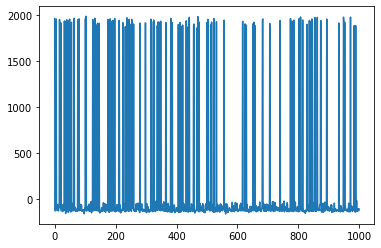

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

average is: 101.59024621258371


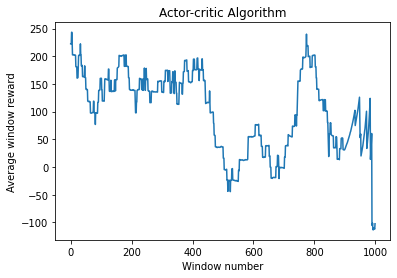

In [ ]:
print("average is:", np.average(window))
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Actor critic (slippery)

false action probability = 0.4

beta = 0.1

In [ ]:
def actor_critc(env, n_components, mu, sigma, alpha, beta, gamma, n_episodes):
    func_approx = []
    for i in range(n_components):
        func_approx.append(multivariate_normal(mean=mu[i], cov=sigma[i]))
        
    mean = np.zeros(n_components)
    cov = np.eye(n_components)
    w = np.random.multivariate_normal(mean, cov)
    theta = np.random.multivariate_normal(mean, cov)
    #theta = 0.0001
    rewards_hist = [] 
    
    for episode in range(n_episodes):
        s = env.reset()
        all_actions = env.get_all_actions()
        a = int(np.random.choice(all_actions, p=policy(func_approx, s, all_actions, theta)))
        if random.uniform(0,1) > 0.6:
            a = random.choice(all_actions)            
        all_rewards = 0
        steps = 0
        while True:
            s_prime, r, done = env.step(a)
            all_rewards += r
            
            a_prime = int(np.random.choice(all_actions, p=policy(func_approx, s_prime, all_actions, theta)))
            Q, phi_s_a = compute_Q(func_approx, s, a, w)
            Q_prime, _ = compute_Q(func_approx, s_prime, a_prime, w)
            delta = r + gamma * Q_prime - Q
            if s_prime == env.win_state:
                print('Congrat')
                print(episode)

            theta += alpha * policy_derivative(func_approx, s, a, all_actions, theta) @ Q

            w += beta * phi_s_a @ delta
            a = a_prime
            steps += 1
            s = s_prime
            if done or steps >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
    return func_approx, theta, rewards_hist            

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.1, 0.1, 0.9, 1000)

Congrat
14
Congrat
25
Congrat
39
Congrat
48
Congrat
50
Congrat
72
Congrat
75
Congrat
79
Congrat
81
Congrat
101
Congrat
122
Congrat
135
Congrat
140
Congrat
145
Congrat
146
Congrat
150
Congrat
152
Congrat
154
Congrat
177
Congrat
198
Congrat
211
Congrat
229
Congrat
260
Congrat
268
Congrat
276
Congrat
281
Congrat
282
Congrat
285
Congrat
288
Congrat
289
Congrat
293
Congrat
294
Congrat
299
Congrat
313
Congrat
318
Congrat
319
Congrat
321
Congrat
325
Congrat
346
Congrat
353
Congrat
369
Congrat
387
Congrat
388
Congrat
394
Congrat
408
Congrat
432
Congrat
433
Congrat
470
Congrat
471
Congrat
473
Congrat
474
Congrat
493
Congrat
504
Congrat
508
Congrat
514
Congrat
532
Congrat
537
Congrat
548
Congrat
549
Congrat
551
Congrat
569
Congrat
577
Congrat
580
Congrat
582
Congrat
589
Congrat
606
Congrat
622
Congrat
634
Congrat
643
Congrat
654
Congrat
663
Congrat
669
Congrat
676
Congrat
690
Congrat
692
Congrat
695
Congrat
698
Congrat
706
Congrat
736
Congrat
744
Congrat
747
Congrat
761
Congrat
785
Congrat
798
C

In [ ]:
max(rewards_hist)

1987.7

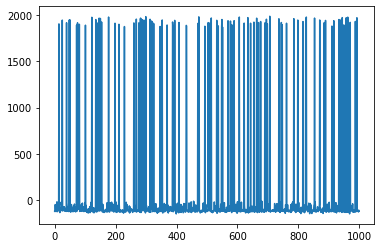

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

average is: 113.8395145231311


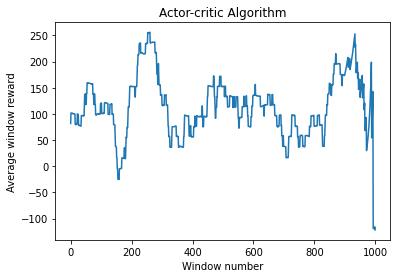

In [ ]:
print("average is:", np.average(window))
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Actor critic (slippery)

false action probability = 0.7

beta = 0.1

In [ ]:
def actor_critc(env, n_components, mu, sigma, alpha, beta, gamma, n_episodes):
    func_approx = []
    for i in range(n_components):
        func_approx.append(multivariate_normal(mean=mu[i], cov=sigma[i]))
        
    mean = np.zeros(n_components)
    cov = np.eye(n_components)
    w = np.random.multivariate_normal(mean, cov)
    theta = np.random.multivariate_normal(mean, cov)
    #theta = 0.0001
    rewards_hist = [] 
    
    for episode in range(n_episodes):
        s = env.reset()
        all_actions = env.get_all_actions()
        a = int(np.random.choice(all_actions, p=policy(func_approx, s, all_actions, theta)))
        if random.uniform(0,1) > 0.3:
            a = random.choice(all_actions)            
        all_rewards = 0
        steps = 0
        while True:
            s_prime, r, done = env.step(a)
            all_rewards += r
            
            a_prime = int(np.random.choice(all_actions, p=policy(func_approx, s_prime, all_actions, theta)))
            Q, phi_s_a = compute_Q(func_approx, s, a, w)
            Q_prime, _ = compute_Q(func_approx, s_prime, a_prime, w)
            delta = r + gamma * Q_prime - Q
            if s_prime == env.win_state:
                print('Congrat')
                print(episode)

            theta += alpha * policy_derivative(func_approx, s, a, all_actions, theta) @ Q

            w += beta * phi_s_a @ delta
            a = a_prime
            steps += 1
            s = s_prime
            if done or steps >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
    return func_approx, theta, rewards_hist            

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.1, 0.1, 0.9, 1000)

Congrat
13
Congrat
16
Congrat
45
Congrat
55
Congrat
57
Congrat
58
Congrat
75
Congrat
84
Congrat
127
Congrat
130
Congrat
133
Congrat
135
Congrat
136
Congrat
140
Congrat
142
Congrat
144
Congrat
149
Congrat
153
Congrat
155
Congrat
165
Congrat
168
Congrat
182
Congrat
192
Congrat
232
Congrat
243
Congrat
245
Congrat
261
Congrat
264
Congrat
266
Congrat
268
Congrat
274
Congrat
285
Congrat
294
Congrat
304
Congrat
311
Congrat
312
Congrat
320
Congrat
324
Congrat
328
Congrat
329
Congrat
331
Congrat
335
Congrat
339
Congrat
344
Congrat
355
Congrat
356
Congrat
374
Congrat
383
Congrat
399
Congrat
400
Congrat
403
Congrat
404
Congrat
405
Congrat
413
Congrat
423
Congrat
444
Congrat
447
Congrat
448
Congrat
451
Congrat
473
Congrat
493
Congrat
499
Congrat
502
Congrat
508
Congrat
510
Congrat
521
Congrat
536
Congrat
537
Congrat
556
Congrat
573
Congrat
592
Congrat
597
Congrat
601
Congrat
605
Congrat
612
Congrat
614
Congrat
631
Congrat
633
Congrat
634
Congrat
640
Congrat
641
Congrat
656
Congrat
679
Congrat
688


In [ ]:
max(rewards_hist)

1979.5

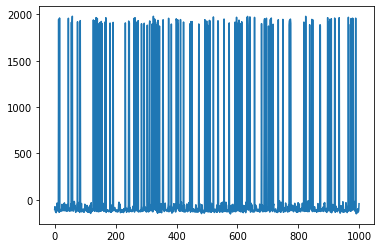

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

average is: 143.41310920303488


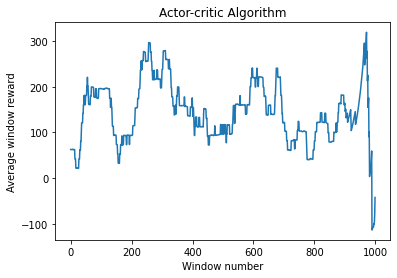

In [ ]:
print("average is:", np.average(window))
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Actor critic

best beta

alpha = 0.5

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.5, 10, 0.9, 1000)

Congrat
20
Congrat
26
Congrat
34
Congrat
39
Congrat
44
Congrat
49
Congrat
50
Congrat
58
Congrat
65
Congrat
81
Congrat
105
Congrat
108
Congrat
109
Congrat
121
Congrat
148
Congrat
156
Congrat
159
Congrat
168
Congrat
180
Congrat
184
Congrat
211
Congrat
215
Congrat
241
Congrat
257
Congrat
265
Congrat
269
Congrat
272
Congrat
277
Congrat
287
Congrat
295
Congrat
296
Congrat
300
Congrat
301
Congrat
303
Congrat
334
Congrat
347
Congrat
359
Congrat
373
Congrat
383
Congrat
404
Congrat
410
Congrat
423
Congrat
428
Congrat
429
Congrat
433
Congrat
434
Congrat
441
Congrat
442
Congrat
444
Congrat
446
Congrat
451
Congrat
462
Congrat
463
Congrat
466
Congrat
481
Congrat
484
Congrat
488
Congrat
515
Congrat
518
Congrat
523
Congrat
536
Congrat
538
Congrat
541
Congrat
567
Congrat
581
Congrat
604
Congrat
615
Congrat
618
Congrat
636
Congrat
657
Congrat
662
Congrat
663
Congrat
669
Congrat
674
Congrat
680
Congrat
696
Congrat
698
Congrat
702
Congrat
705
Congrat
707
Congrat
708
Congrat
710
Congrat
747
Congrat
758
Co

In [ ]:
max(rewards_hist)

1988.0

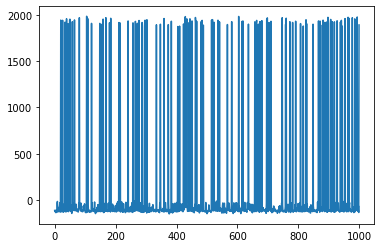

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

average is: 140.11090254129522


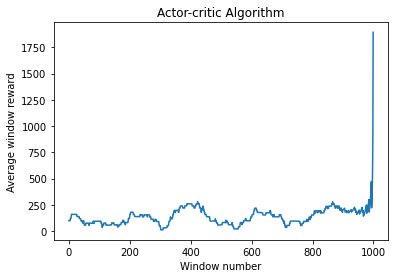

In [ ]:
print("average is:", np.average(window))
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Actor critic

best beta

alpha = 0.9

In [ ]:
mu = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]
func_approx, theta, rewards_hist = actor_critc(env, 4, mu, sigma, 0.9, 10, 0.9, 1000)

Congrat
22
Congrat
24
Congrat
25
Congrat
38
Congrat
44
Congrat
57
Congrat
68
Congrat
79
Congrat
81
Congrat
85
Congrat
86
Congrat
95
Congrat
99
Congrat
105
Congrat
106
Congrat
120
Congrat
122
Congrat
125
Congrat
127
Congrat
134
Congrat
144
Congrat
147
Congrat
157
Congrat
159
Congrat
168
Congrat
180
Congrat
181
Congrat
193
Congrat
203
Congrat
204
Congrat
211
Congrat
221
Congrat
222
Congrat
229
Congrat
260
Congrat
271
Congrat
277
Congrat
279
Congrat
280
Congrat
290
Congrat
291
Congrat
292
Congrat
294
Congrat
296
Congrat
303
Congrat
304
Congrat
313
Congrat
316
Congrat
330
Congrat
332
Congrat
339
Congrat
355
Congrat
360
Congrat
376
Congrat
387
Congrat
388
Congrat
415
Congrat
428
Congrat
430
Congrat
440
Congrat
448
Congrat
478
Congrat
481
Congrat
497
Congrat
509
Congrat
520
Congrat
526
Congrat
542
Congrat
543
Congrat
571
Congrat
601
Congrat
612
Congrat
622
Congrat
627
Congrat
631
Congrat
654
Congrat
657
Congrat
659
Congrat
668
Congrat
671
Congrat
672
Congrat
677
Congrat
687
Congrat
698
Congr

In [ ]:
max(rewards_hist)

1987.9

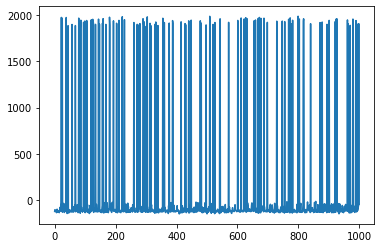

In [ ]:
plt.plot(rewards_hist)

In [ ]:
window = []
for i in range (len(rewards_hist)):
    window.append(sum(rewards_hist[i:i+101]) / len(rewards_hist[i:i+101]))

average is: 130.13266002012895


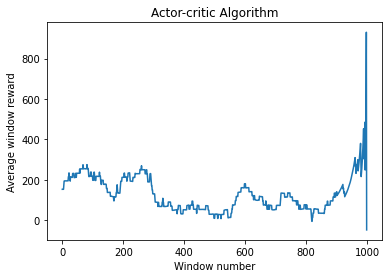

In [ ]:
print("average is:", np.average(window))
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Actor-critic Algorithm');

# Multi-agent algorithms

## Belief-Based algorithm

In [7]:
def state_map(n_agents, all_states, win_state):
    state_dict = {}
    counter = 0
    goal_states = []
    for state1 in all_states:
        for state2 in all_states:
            if state1+state2 not in state_dict.keys():
                state_dict[state1+state2] = counter
                counter += 1
                if state1 == win_state or state2 == win_state:
                    goal_states.append(counter)
                
    return state_dict, goal_states       

In [8]:
def belief_based_algorithm(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()
                
                
    rewards_hist = []            
    a1_probs = np.ones((len(state_dict), len(all_actions)))
    a2_probs = np.ones((len(state_dict), len(all_actions))) 
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                best_value = -np.inf
                best_action  = 8
                for A1 in all_actions:
                    temp = 0
                    for A2 in all_actions:
                        temp += a2_probs[s,A2] * Q_table_1[s, A1, A2]
                    if temp > best_value:
                        best_value = temp
                        best_action = A1
                    
                a1 = best_action
                
            else:
                a1 = random.choice(all_actions)
                
            a1_probs[s,a1] += 1    
            
            if random.uniform(0, 1) > eps:
                best_value = -np.inf
                best_action  = 8
                for A2 in all_actions:
                    temp = 0
                    for A1 in all_actions:
                        temp += a1_probs[s,A1] * Q_table_2[s, A1, A2]
                    if temp > best_value:
                        best_value = temp
                        best_action = A2
                    
                a2 = best_action
                
            else:
                a2 = random.choice(all_actions)
                
            a2_probs[s,a2] += 1     

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#           r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            best_value1 = -np.inf
            for A1 in all_actions:
                temp = 0
                for A2 in all_actions:
                    temp += (a2_probs[next_state,A2] / sum(a2_probs[next_state,:])) * Q_table_1[s, A1, A2]
                if temp > best_value1:
                    best_value1 = temp
                        
            best_value2 = -np.inf
            for A2 in all_actions:
                temp = 0
                for A1 in all_actions:
                    temp += (a1_probs[next_state,A1] / sum(a1_probs[next_state,:])) * Q_table_2[s, A1, A2]
                if temp > best_value2:
                    best_value2 = temp
    
            Q_table_1[s,a1,a2] += alpha * (r + gamma * best_value1 - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * best_value2 - Q_table_2[s,a1,a2])
            s = next_state
            
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [9]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = belief_based_algorithm(env1, env2, 0.99, 0.1, 0.9999, 2200, 2)

2
Congrat
5
Congrat
7
Congrat
26
Congrat
28
Congrat
29
Congrat
31
Congrat
32
Congrat
38
Congrat
41
Congrat
46
Congrat
47
Congrat
53
Congrat
54
Congrat
56
Congrat
57
Congrat
61
Congrat
65
Congrat
66
Congrat
67
Congrat
68
Congrat
69
Congrat
74
Congrat
80
Congrat
83
Congrat
92
Congrat
101
Congrat
103
Congrat
108
Congrat
110
Congrat
112
Congrat
113
Congrat
114
Congrat
115
Congrat
118
Congrat
119
Congrat
121
Congrat
124
Congrat
126
Congrat
129
Congrat
132
Congrat
134
Congrat
139
Congrat
140
Congrat
141
Congrat
143
Congrat
145
Congrat
147
Congrat
148
Congrat
154
Congrat
155
Congrat
158
Congrat
159
Congrat
161
Congrat
162
Congrat
165
Congrat
167
Congrat
169
Congrat
170
Congrat
171
Congrat
172
Congrat
180
Congrat
183
Congrat
185
Congrat
187
Congrat
192
Congrat
196
Congrat
202
Congrat
205
Congrat
209
Congrat
210
Congrat
212
Congrat
213
Congrat
214
Congrat
215
Congrat
218
Congrat
219
Congrat
220
Congrat
221
Congrat
224
Congrat
225
Congrat
226
Congrat
227
Congrat
230
Congrat
232
Congrat
239
Congr

1365
Congrat
1368
Congrat
1370
Congrat
1371
Congrat
1372
Congrat
1374
Congrat
1376
Congrat
1377
Congrat
1378
Congrat
1381
Congrat
1382
Congrat
1383
Congrat
1386
Congrat
1388
Congrat
1389
Congrat
1390
Congrat
1391
Congrat
1392
Congrat
1394
Congrat
1396
Congrat
1397
Congrat
1398
Congrat
1400
Congrat
1401
Congrat
1402
Congrat
1403
Congrat
1404
Congrat
1405
Congrat
1407
Congrat
1409
Congrat
1411
Congrat
1412
Congrat
1414
Congrat
1415
Congrat
1416
Congrat
1417
Congrat
1418
Congrat
1419
Congrat
1421
Congrat
1422
Congrat
1423
Congrat
1425
Congrat
1428
Congrat
1430
Congrat
1431
Congrat
1432
Congrat
1433
Congrat
1435
Congrat
1436
Congrat
1437
Congrat
1438
Congrat
1439
Congrat
1442
Congrat
1443
Congrat
1444
Congrat
1445
Congrat
1446
Congrat
1447
Congrat
1449
Congrat
1450
Congrat
1452
Congrat
1453
Congrat
1455
Congrat
1456
Congrat
1458
Congrat
1459
Congrat
1460
Congrat
1463
Congrat
1464
Congrat
1465
Congrat
1466
Congrat
1467
Congrat
1468
Congrat
1469
Congrat
1471
Congrat
1474
Congrat
1475
Congrat

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

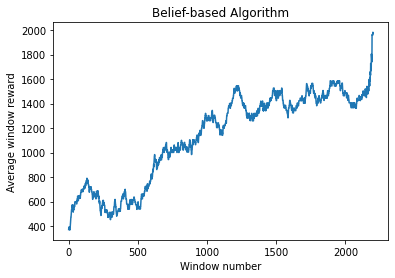

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Belief-based Algorithm');

## Belief-Based algorithm

gamma = 0.1

In [10]:
hist = belief_based_algorithm(env1, env2, 0.99, 0.1, 0.1, 2200, 2)

3
Congrat
4
Congrat
8
Congrat
9
Congrat
10
Congrat
17
Congrat
19
Congrat
25
Congrat
27
Congrat
30
Congrat
33
Congrat
35
Congrat
39
Congrat
40
Congrat
44
Congrat
48
Congrat
53
Congrat
62
Congrat
63
Congrat
66
Congrat
67
Congrat
68
Congrat
71
Congrat
73
Congrat
79
Congrat
84
Congrat
88
Congrat
89
Congrat
94
Congrat
95
Congrat
100
Congrat
101
Congrat
104
Congrat
105
Congrat
112
Congrat
113
Congrat
114
Congrat
115
Congrat
120
Congrat
122
Congrat
140
Congrat
141
Congrat
145
Congrat
146
Congrat
149
Congrat
151
Congrat
154
Congrat
155
Congrat
158
Congrat
160
Congrat
164
Congrat
165
Congrat
166
Congrat
168
Congrat
169
Congrat
170
Congrat
172
Congrat
173
Congrat
175
Congrat
182
Congrat
185
Congrat
189
Congrat
191
Congrat
192
Congrat
194
Congrat
196
Congrat
203
Congrat
206
Congrat
209
Congrat
213
Congrat
216
Congrat
217
Congrat
220
Congrat
221
Congrat
224
Congrat
225
Congrat
231
Congrat
236
Congrat
237
Congrat
242
Congrat
250
Congrat
251
Congrat
254
Congrat
259
Congrat
262
Congrat
263
Congrat
26

In [11]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

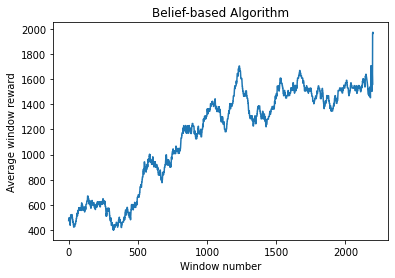

In [12]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Belief-based Algorithm');

## Belief-Based algorithm

gamma = 0.4

In [13]:
hist = belief_based_algorithm(env1, env2, 0.99, 0.1, 0.4, 2200, 2)

2
Congrat
7
Congrat
13
Congrat
15
Congrat
18
Congrat
24
Congrat
36
Congrat
37
Congrat
46
Congrat
49
Congrat
55
Congrat
59
Congrat
61
Congrat
63
Congrat
64
Congrat
67
Congrat
68
Congrat
77
Congrat
79
Congrat
81
Congrat
84
Congrat
89
Congrat
92
Congrat
97
Congrat
99
Congrat
101
Congrat
109
Congrat
111
Congrat
113
Congrat
118
Congrat
121
Congrat
126
Congrat
130
Congrat
131
Congrat
134
Congrat
136
Congrat
139
Congrat
141
Congrat
142
Congrat
146
Congrat
148
Congrat
152
Congrat
153
Congrat
154
Congrat
158
Congrat
161
Congrat
162
Congrat
165
Congrat
166
Congrat
169
Congrat
170
Congrat
174
Congrat
179
Congrat
180
Congrat
183
Congrat
184
Congrat
196
Congrat
201
Congrat
202
Congrat
203
Congrat
204
Congrat
206
Congrat
209
Congrat
210
Congrat
211
Congrat
212
Congrat
215
Congrat
218
Congrat
219
Congrat
225
Congrat
228
Congrat
230
Congrat
231
Congrat
232
Congrat
233
Congrat
234
Congrat
236
Congrat
237
Congrat
240
Congrat
241
Congrat
242
Congrat
243
Congrat
247
Congrat
248
Congrat
250
Congrat
251
Con

In [14]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

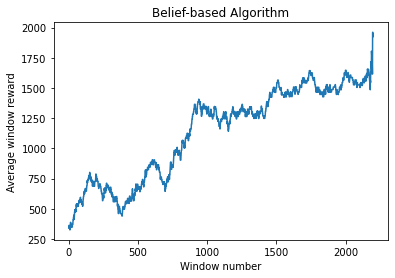

In [15]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Belief-based Algorithm');

## Belief-Based algorithm

gamma = 0.9

In [16]:
hist = belief_based_algorithm(env1, env2, 0.99, 0.1, 0.9, 2200, 2)

5
Congrat
9
Congrat
10
Congrat
13
Congrat
15
Congrat
20
Congrat
21
Congrat
22
Congrat
24
Congrat
26
Congrat
30
Congrat
32
Congrat
37
Congrat
38
Congrat
47
Congrat
49
Congrat
52
Congrat
57
Congrat
63
Congrat
68
Congrat
71
Congrat
72
Congrat
77
Congrat
79
Congrat
85
Congrat
87
Congrat
90
Congrat
92
Congrat
94
Congrat
97
Congrat
101
Congrat
103
Congrat
106
Congrat
107
Congrat
109
Congrat
112
Congrat
114
Congrat
116
Congrat
117
Congrat
121
Congrat
123
Congrat
125
Congrat
128
Congrat
129
Congrat
130
Congrat
131
Congrat
132
Congrat
134
Congrat
141
Congrat
145
Congrat
151
Congrat
152
Congrat
153
Congrat
154
Congrat
159
Congrat
160
Congrat
165
Congrat
167
Congrat
168
Congrat
170
Congrat
171
Congrat
178
Congrat
181
Congrat
185
Congrat
188
Congrat
190
Congrat
193
Congrat
195
Congrat
197
Congrat
201
Congrat
204
Congrat
206
Congrat
216
Congrat
218
Congrat
219
Congrat
220
Congrat
221
Congrat
223
Congrat
225
Congrat
227
Congrat
229
Congrat
230
Congrat
232
Congrat
233
Congrat
234
Congrat
236
Congrat


In [17]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

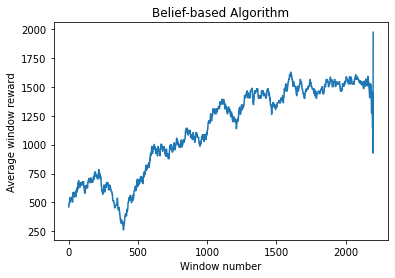

In [18]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Belief-based Algorithm');

## Belief-Based algorithm (slippery)

false action probability = 0.1

In [ ]:
def belief_based_algorithm(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()
                
                
    rewards_hist = []            
    a1_probs = np.ones((len(state_dict), len(all_actions)))
    a2_probs = np.ones((len(state_dict), len(all_actions))) 
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                best_value = -np.inf
                best_action  = 8
                for A1 in all_actions:
                    temp = 0
                    for A2 in all_actions:
                        temp += a2_probs[s,A2] * Q_table_1[s, A1, A2]
                    if temp > best_value:
                        best_value = temp
                        best_action = A1
                    
                a1 = best_action
                if random.uniform(0,1) > 0.9:
                    a1 = random.choice(all_actions)         
                
            else:
                a1 = random.choice(all_actions)
                
            a1_probs[s,a1] += 1    
            
            if random.uniform(0, 1) > eps:
                best_value = -np.inf
                best_action  = 8
                for A2 in all_actions:
                    temp = 0
                    for A1 in all_actions:
                        temp += a1_probs[s,A1] * Q_table_2[s, A1, A2]
                    if temp > best_value:
                        best_value = temp
                        best_action = A2
                    
                a2 = best_action
                if random.uniform(0,1) > 0.9:
                    a2 = random.choice(all_actions)         
            
            else:
                a2 = random.choice(all_actions)
                
            a2_probs[s,a2] += 1     

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#           r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            best_value1 = -np.inf
            for A1 in all_actions:
                temp = 0
                for A2 in all_actions:
                    temp += (a2_probs[next_state,A2] / sum(a2_probs[next_state,:])) * Q_table_1[s, A1, A2]
                if temp > best_value1:
                    best_value1 = temp
                        
            best_value2 = -np.inf
            for A2 in all_actions:
                temp = 0
                for A1 in all_actions:
                    temp += (a1_probs[next_state,A1] / sum(a1_probs[next_state,:])) * Q_table_2[s, A1, A2]
                if temp > best_value2:
                    best_value2 = temp
    
            Q_table_1[s,a1,a2] += alpha * (r + gamma * best_value1 - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * best_value2 - Q_table_2[s,a1,a2])
            s = next_state
            
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [ ]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = belief_based_algorithm(env1, env2, 0.99, 0.1, 0.9999, 2200, 2)

0
Congrat
6
Congrat
7
Congrat
12
Congrat
23
Congrat
24
Congrat
30
Congrat
34
Congrat
38
Congrat
39
Congrat
41
Congrat
42
Congrat
44
Congrat
45
Congrat
49
Congrat
52
Congrat
53
Congrat
55
Congrat
56
Congrat
57
Congrat
62
Congrat
70
Congrat
75
Congrat
82
Congrat
85
Congrat
90
Congrat
93
Congrat
102
Congrat
104
Congrat
106
Congrat
111
Congrat
114
Congrat
118
Congrat
121
Congrat
126
Congrat
135
Congrat
136
Congrat
139
Congrat
141
Congrat
144
Congrat
148
Congrat
153
Congrat
155
Congrat
158
Congrat
163
Congrat
166
Congrat
171
Congrat
172
Congrat
180
Congrat
181
Congrat
182
Congrat
184
Congrat
190
Congrat
191
Congrat
193
Congrat
195
Congrat
197
Congrat
198
Congrat
199
Congrat
201
Congrat
203
Congrat
208
Congrat
209
Congrat
211
Congrat
214
Congrat
215
Congrat
220
Congrat
222
Congrat
223
Congrat
228
Congrat
229
Congrat
233
Congrat
244
Congrat
247
Congrat
249
Congrat
260
Congrat
265
Congrat
266
Congrat
267
Congrat
274
Congrat
276
Congrat
278
Congrat
279
Congrat
281
Congrat
282
Congrat
283
Congra

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

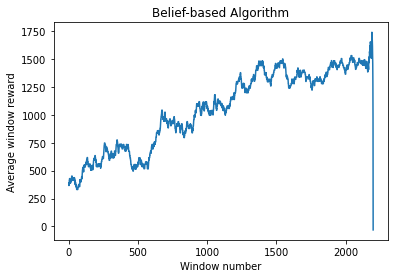

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Belief-based Algorithm');

## Belief-Based algorithm (slippery)

false action probability = 0.4

In [ ]:
def belief_based_algorithm(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()
                
                
    rewards_hist = []            
    a1_probs = np.ones((len(state_dict), len(all_actions)))
    a2_probs = np.ones((len(state_dict), len(all_actions))) 
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                best_value = -np.inf
                best_action  = 8
                for A1 in all_actions:
                    temp = 0
                    for A2 in all_actions:
                        temp += a2_probs[s,A2] * Q_table_1[s, A1, A2]
                    if temp > best_value:
                        best_value = temp
                        best_action = A1
                    
                a1 = best_action
                if random.uniform(0,1) > 0.6:
                    a1 = random.choice(all_actions)         
                
            else:
                a1 = random.choice(all_actions)
                
            a1_probs[s,a1] += 1    
            
            if random.uniform(0, 1) > eps:
                best_value = -np.inf
                best_action  = 8
                for A2 in all_actions:
                    temp = 0
                    for A1 in all_actions:
                        temp += a1_probs[s,A1] * Q_table_2[s, A1, A2]
                    if temp > best_value:
                        best_value = temp
                        best_action = A2
                    
                a2 = best_action
                if random.uniform(0,1) > 0.6:
                    a2 = random.choice(all_actions)         
            
            else:
                a2 = random.choice(all_actions)
                
            a2_probs[s,a2] += 1     

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#           r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            best_value1 = -np.inf
            for A1 in all_actions:
                temp = 0
                for A2 in all_actions:
                    temp += (a2_probs[next_state,A2] / sum(a2_probs[next_state,:])) * Q_table_1[s, A1, A2]
                if temp > best_value1:
                    best_value1 = temp
                        
            best_value2 = -np.inf
            for A2 in all_actions:
                temp = 0
                for A1 in all_actions:
                    temp += (a1_probs[next_state,A1] / sum(a1_probs[next_state,:])) * Q_table_2[s, A1, A2]
                if temp > best_value2:
                    best_value2 = temp
    
            Q_table_1[s,a1,a2] += alpha * (r + gamma * best_value1 - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * best_value2 - Q_table_2[s,a1,a2])
            s = next_state
            
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [ ]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = belief_based_algorithm(env1, env2, 0.99, 0.1, 0.9999, 2200, 2)

4
Congrat
11
Congrat
15
Congrat
17
Congrat
22
Congrat
24
Congrat
25
Congrat
31
Congrat
33
Congrat
41
Congrat
42
Congrat
45
Congrat
50
Congrat
55
Congrat
59
Congrat
66
Congrat
75
Congrat
79
Congrat
82
Congrat
84
Congrat
89
Congrat
90
Congrat
96
Congrat
100
Congrat
102
Congrat
105
Congrat
108
Congrat
110
Congrat
112
Congrat
115
Congrat
116
Congrat
117
Congrat
129
Congrat
134
Congrat
135
Congrat
136
Congrat
143
Congrat
145
Congrat
146
Congrat
151
Congrat
152
Congrat
157
Congrat
165
Congrat
171
Congrat
175
Congrat
176
Congrat
188
Congrat
200
Congrat
203
Congrat
207
Congrat
208
Congrat
209
Congrat
212
Congrat
216
Congrat
220
Congrat
225
Congrat
226
Congrat
228
Congrat
229
Congrat
231
Congrat
235
Congrat
236
Congrat
241
Congrat
246
Congrat
250
Congrat
253
Congrat
254
Congrat
256
Congrat
257
Congrat
259
Congrat
260
Congrat
270
Congrat
276
Congrat
280
Congrat
285
Congrat
287
Congrat
290
Congrat
296
Congrat
297
Congrat
300
Congrat
302
Congrat
303
Congrat
309
Congrat
310
Congrat
312
Congrat
316


In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

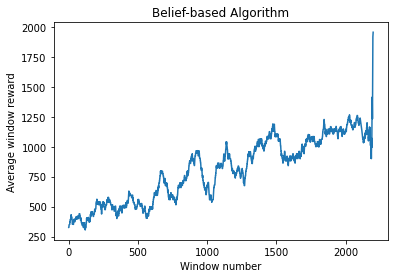

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Belief-based Algorithm');

## Belief-Based algorithm (slippery)

false action probability = 0.7

In [ ]:
def belief_based_algorithm(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()
                
                
    rewards_hist = []            
    a1_probs = np.ones((len(state_dict), len(all_actions)))
    a2_probs = np.ones((len(state_dict), len(all_actions))) 
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                best_value = -np.inf
                best_action  = 8
                for A1 in all_actions:
                    temp = 0
                    for A2 in all_actions:
                        temp += a2_probs[s,A2] * Q_table_1[s, A1, A2]
                    if temp > best_value:
                        best_value = temp
                        best_action = A1
                    
                a1 = best_action
                if random.uniform(0,1) > 0.3:
                    a1 = random.choice(all_actions)         
                
            else:
                a1 = random.choice(all_actions)
                
            a1_probs[s,a1] += 1    
            
            if random.uniform(0, 1) > eps:
                best_value = -np.inf
                best_action  = 8
                for A2 in all_actions:
                    temp = 0
                    for A1 in all_actions:
                        temp += a1_probs[s,A1] * Q_table_2[s, A1, A2]
                    if temp > best_value:
                        best_value = temp
                        best_action = A2
                    
                a2 = best_action
                if random.uniform(0,1) > 0.3:
                    a2 = random.choice(all_actions)         
            
            else:
                a2 = random.choice(all_actions)
                
            a2_probs[s,a2] += 1     

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#           r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            best_value1 = -np.inf
            for A1 in all_actions:
                temp = 0
                for A2 in all_actions:
                    temp += (a2_probs[next_state,A2] / sum(a2_probs[next_state,:])) * Q_table_1[s, A1, A2]
                if temp > best_value1:
                    best_value1 = temp
                        
            best_value2 = -np.inf
            for A2 in all_actions:
                temp = 0
                for A1 in all_actions:
                    temp += (a1_probs[next_state,A1] / sum(a1_probs[next_state,:])) * Q_table_2[s, A1, A2]
                if temp > best_value2:
                    best_value2 = temp
    
            Q_table_1[s,a1,a2] += alpha * (r + gamma * best_value1 - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * best_value2 - Q_table_2[s,a1,a2])
            s = next_state
            
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [ ]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = belief_based_algorithm(env1, env2, 0.99, 0.1, 0.9999, 2200, 2)

3
Congrat
4
Congrat
9
Congrat
13
Congrat
21
Congrat
23
Congrat
24
Congrat
26
Congrat
31
Congrat
34
Congrat
35
Congrat
37
Congrat
40
Congrat
45
Congrat
49
Congrat
53
Congrat
57
Congrat
58
Congrat
61
Congrat
64
Congrat
79
Congrat
81
Congrat
84
Congrat
88
Congrat
93
Congrat
95
Congrat
99
Congrat
101
Congrat
102
Congrat
105
Congrat
106
Congrat
134
Congrat
136
Congrat
138
Congrat
139
Congrat
140
Congrat
141
Congrat
144
Congrat
145
Congrat
149
Congrat
154
Congrat
163
Congrat
166
Congrat
168
Congrat
169
Congrat
178
Congrat
190
Congrat
194
Congrat
197
Congrat
200
Congrat
201
Congrat
208
Congrat
210
Congrat
218
Congrat
219
Congrat
224
Congrat
232
Congrat
233
Congrat
236
Congrat
238
Congrat
244
Congrat
249
Congrat
257
Congrat
261
Congrat
263
Congrat
265
Congrat
267
Congrat
269
Congrat
273
Congrat
277
Congrat
280
Congrat
281
Congrat
284
Congrat
294
Congrat
296
Congrat
298
Congrat
304
Congrat
305
Congrat
310
Congrat
315
Congrat
316
Congrat
318
Congrat
324
Congrat
328
Congrat
331
Congrat
332
Congra

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

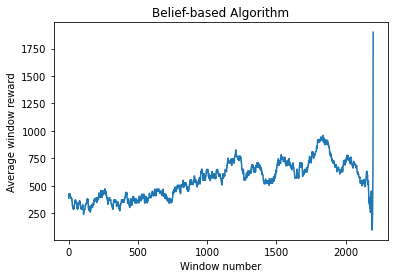

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Belief-based Algorithm');

## Multi-agent Sarsa 

In [19]:
def multi_agent_sarsa(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()
    
                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        if random.uniform(0, 1) > eps:
            a1 = np.argmax(np.max(Q_table_1[s,:,:], axis=1))
        else:
            a1 = random.choice(all_actions)
            
        if random.uniform(0, 1) > eps:
            a2 = np.argmax(np.max(Q_table_2[s,:,:], axis=0))
        else:
            a2 = random.choice(all_actions)
            
        all_rewards = 0
        step = 0
        while True:
            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            s_prime = state_dict[s1_prime + s2_prime]
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
                
            if random.uniform(0, 1) > eps:
                a1_prime = np.argmax(np.max(Q_table_1[s_prime,:,:], axis=1))
            else:
                a1_prime = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a2_prime = np.argmax(np.max(Q_table_2[s_prime,:,:], axis=0))
            else:
                a2_prime = random.choice(all_actions)    
                
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            Q_table_1[s,a1,a2] += alpha * (r + gamma * Q_table_1[s_prime,a1_prime,a2_prime] - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * Q_table_2[s_prime,a1_prime,a2_prime] - Q_table_2[s,a1,a2])
            s = s_prime
            a1 = a1_prime
            a2 = a2_prime
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [20]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = multi_agent_sarsa(env1, env2, 0.99, 0.1, 0.9999, 2200, 2)

2
Congrat
8
Congrat
13
Congrat
15
Congrat
17
Congrat
19
Congrat
26
Congrat
27
Congrat
28
Congrat
29
Congrat
32
Congrat
33
Congrat
36
Congrat
41
Congrat
42
Congrat
46
Congrat
48
Congrat
52
Congrat
54
Congrat
55
Congrat
57
Congrat
63
Congrat
64
Congrat
66
Congrat
67
Congrat
70
Congrat
71
Congrat
73
Congrat
75
Congrat
77
Congrat
78
Congrat
79
Congrat
83
Congrat
84
Congrat
85
Congrat
86
Congrat
90
Congrat
91
Congrat
92
Congrat
93
Congrat
95
Congrat
104
Congrat
105
Congrat
106
Congrat
107
Congrat
109
Congrat
110
Congrat
112
Congrat
113
Congrat
114
Congrat
118
Congrat
120
Congrat
122
Congrat
124
Congrat
125
Congrat
126
Congrat
127
Congrat
128
Congrat
129
Congrat
132
Congrat
135
Congrat
136
Congrat
138
Congrat
139
Congrat
140
Congrat
141
Congrat
142
Congrat
143
Congrat
144
Congrat
145
Congrat
146
Congrat
147
Congrat
148
Congrat
149
Congrat
150
Congrat
151
Congrat
152
Congrat
153
Congrat
154
Congrat
155
Congrat
156
Congrat
157
Congrat
158
Congrat
159
Congrat
160
Congrat
161
Congrat
164
Congrat

1097
Congrat
1098
Congrat
1099
Congrat
1100
Congrat
1101
Congrat
1102
Congrat
1103
Congrat
1104
Congrat
1105
Congrat
1106
Congrat
1107
Congrat
1108
Congrat
1109
Congrat
1110
Congrat
1111
Congrat
1112
Congrat
1113
Congrat
1114
Congrat
1115
Congrat
1116
Congrat
1117
Congrat
1118
Congrat
1119
Congrat
1120
Congrat
1121
Congrat
1122
Congrat
1123
Congrat
1124
Congrat
1125
Congrat
1126
Congrat
1127
Congrat
1128
Congrat
1129
Congrat
1130
Congrat
1131
Congrat
1132
Congrat
1133
Congrat
1134
Congrat
1135
Congrat
1136
Congrat
1137
Congrat
1138
Congrat
1139
Congrat
1140
Congrat
1141
Congrat
1142
Congrat
1143
Congrat
1144
Congrat
1145
Congrat
1146
Congrat
1147
Congrat
1148
Congrat
1149
Congrat
1150
Congrat
1151
Congrat
1152
Congrat
1153
Congrat
1154
Congrat
1155
Congrat
1156
Congrat
1157
Congrat
1158
Congrat
1159
Congrat
1160
Congrat
1161
Congrat
1162
Congrat
1163
Congrat
1164
Congrat
1165
Congrat
1166
Congrat
1167
Congrat
1168
Congrat
1169
Congrat
1170
Congrat
1171
Congrat
1172
Congrat
1173
Congrat

1775
Congrat
1776
Congrat
1777
Congrat
1778
Congrat
1779
Congrat
1780
Congrat
1781
Congrat
1782
Congrat
1783
Congrat
1784
Congrat
1785
Congrat
1786
Congrat
1787
Congrat
1788
Congrat
1789
Congrat
1790
Congrat
1791
Congrat
1792
Congrat
1793
Congrat
1794
Congrat
1795
Congrat
1796
Congrat
1797
Congrat
1798
Congrat
1799
Congrat
1800
Congrat
1801
Congrat
1802
Congrat
1803
Congrat
1804
Congrat
1805
Congrat
1806
Congrat
1807
Congrat
1808
Congrat
1809
Congrat
1810
Congrat
1811
Congrat
1812
Congrat
1813
Congrat
1814
Congrat
1815
Congrat
1816
Congrat
1817
Congrat
1818
Congrat
1819
Congrat
1820
Congrat
1821
Congrat
1822
Congrat
1823
Congrat
1824
Congrat
1825
Congrat
1826
Congrat
1827
Congrat
1828
Congrat
1829
Congrat
1830
Congrat
1831
Congrat
1832
Congrat
1833
Congrat
1834
Congrat
1835
Congrat
1836
Congrat
1837
Congrat
1838
Congrat
1839
Congrat
1840
Congrat
1841
Congrat
1842
Congrat
1843
Congrat
1844
Congrat
1845
Congrat
1846
Congrat
1847
Congrat
1848
Congrat
1849
Congrat
1850
Congrat
1851
Congrat

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

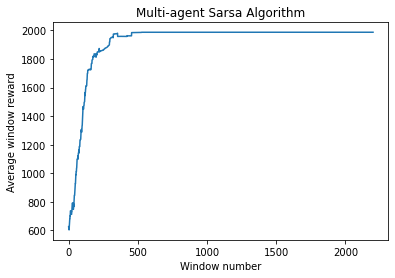

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Multi-agent Sarsa Algorithm');

## Multi-agent Sarsa 

gamma = 0.1

In [21]:
hist = multi_agent_sarsa(env1, env2, 0.99, 0.1, 0.1, 2200, 2)

6
Congrat
8
Congrat
9
Congrat
10
Congrat
13
Congrat
14
Congrat
15
Congrat
19
Congrat
20
Congrat
25
Congrat
27
Congrat
33
Congrat
39
Congrat
40
Congrat
41
Congrat
42
Congrat
43
Congrat
45
Congrat
47
Congrat
48
Congrat
50
Congrat
52
Congrat
54
Congrat
58
Congrat
60
Congrat
62
Congrat
64
Congrat
65
Congrat
67
Congrat
69
Congrat
71
Congrat
73
Congrat
75
Congrat
76
Congrat
78
Congrat
79
Congrat
80
Congrat
82
Congrat
84
Congrat
86
Congrat
87
Congrat
89
Congrat
96
Congrat
98
Congrat
99
Congrat
100
Congrat
110
Congrat
112
Congrat
116
Congrat
122
Congrat
127
Congrat
128
Congrat
129
Congrat
130
Congrat
139
Congrat
156
Congrat
158
Congrat
159
Congrat
160
Congrat
161
Congrat
162
Congrat
163
Congrat
164
Congrat
167
Congrat
170
Congrat
174
Congrat
175
Congrat
178
Congrat
179
Congrat
180
Congrat
182
Congrat
184
Congrat
185
Congrat
186
Congrat
187
Congrat
188
Congrat
190
Congrat
194
Congrat
198
Congrat
199
Congrat
201
Congrat
202
Congrat
203
Congrat
204
Congrat
211
Congrat
213
Congrat
219
Congrat
224


In [22]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

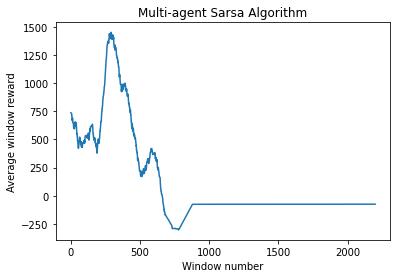

In [23]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Multi-agent Sarsa Algorithm');

## Multi-agent Sarsa 

gamma = 0.4

In [24]:
hist = multi_agent_sarsa(env1, env2, 0.99, 0.1, 0.4, 2200, 2)

3
Congrat
5
Congrat
6
Congrat
10
Congrat
11
Congrat
16
Congrat
18
Congrat
21
Congrat
22
Congrat
26
Congrat
27
Congrat
31
Congrat
46
Congrat
49
Congrat
55
Congrat
61
Congrat
65
Congrat
66
Congrat
69
Congrat
70
Congrat
78
Congrat
79
Congrat
84
Congrat
86
Congrat
87
Congrat
89
Congrat
92
Congrat
98
Congrat
99
Congrat
101
Congrat
103
Congrat
105
Congrat
106
Congrat
107
Congrat
109
Congrat
111
Congrat
115
Congrat
120
Congrat
125
Congrat
126
Congrat
128
Congrat
131
Congrat
133
Congrat
141
Congrat
143
Congrat
144
Congrat
150
Congrat
153
Congrat
162
Congrat
170
Congrat
171
Congrat
177
Congrat
178
Congrat
179
Congrat
180
Congrat
181
Congrat
182
Congrat
183
Congrat
188
Congrat
189
Congrat
190
Congrat
191
Congrat
193
Congrat
194
Congrat
195
Congrat
196
Congrat
197
Congrat
198
Congrat
199
Congrat
200
Congrat
201
Congrat
205
Congrat
207
Congrat
208
Congrat
209
Congrat
210
Congrat
211
Congrat
212
Congrat
213
Congrat
214
Congrat
216
Congrat
217
Congrat
218
Congrat
220
Congrat
221
Congrat
222
Congrat


In [25]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

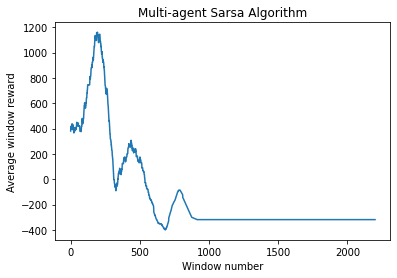

In [26]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Multi-agent Sarsa Algorithm');

## Multi-agent Sarsa 

gamma = 0.9

In [27]:
hist = multi_agent_sarsa(env1, env2, 0.99, 0.1, 0.9, 2200, 2)

5
Congrat
6
Congrat
10
Congrat
12
Congrat
18
Congrat
36
Congrat
39
Congrat
47
Congrat
53
Congrat
55
Congrat
56
Congrat
57
Congrat
58
Congrat
60
Congrat
61
Congrat
62
Congrat
64
Congrat
66
Congrat
67
Congrat
68
Congrat
69
Congrat
71
Congrat
76
Congrat
77
Congrat
80
Congrat
83
Congrat
85
Congrat
88
Congrat
89
Congrat
94
Congrat
97
Congrat
98
Congrat
101
Congrat
104
Congrat
107
Congrat
109
Congrat
118
Congrat
119
Congrat
120
Congrat
123
Congrat
125
Congrat
126
Congrat
128
Congrat
129
Congrat
142
Congrat
144
Congrat
154
Congrat
155
Congrat
162
Congrat
167
Congrat
175
Congrat
179
Congrat
181
Congrat
188
Congrat
192
Congrat
199
Congrat
202
Congrat
209
Congrat
210
Congrat
220
Congrat
228
Congrat
237
Congrat
252
Congrat
253
Congrat
255
Congrat
258
Congrat
260
Congrat
261
Congrat
262
Congrat
264
Congrat
265
Congrat
267
Congrat
279
Congrat
281
Congrat
282
Congrat
285
Congrat
287
Congrat
289
Congrat
290
Congrat
291
Congrat
293
Congrat
294
Congrat
296
Congrat
297
Congrat
298
Congrat
299
Congrat
30

In [28]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

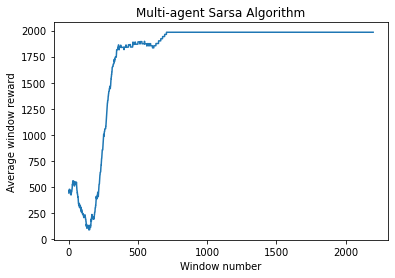

In [29]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Multi-agent Sarsa Algorithm');

## Multi-agent Sarsa (slippery)

false action probability = 0.1

In [ ]:
def multi_agent_sarsa(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        if random.uniform(0, 1) > eps:
            a1 = np.argmax(np.max(Q_table_1[s,:,:], axis=1))
            if random.uniform(0,1) > 0.9:
                a1 = random.choice(all_actions)             

        else:
            a1 = random.choice(all_actions)
            
        if random.uniform(0, 1) > eps:
            a2 = np.argmax(np.max(Q_table_2[s,:,:], axis=0))
            if random.uniform(0,1) > 0.9:
                a2 = random.choice(all_actions)         
        
        else:
            a2 = random.choice(all_actions)
            
        all_rewards = 0
        step = 0
        while True:
            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            s_prime = state_dict[s1_prime + s2_prime]
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
                
            if random.uniform(0, 1) > eps:
                a1_prime = np.argmax(np.max(Q_table_1[s_prime,:,:], axis=1))
            else:
                a1_prime = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a2_prime = np.argmax(np.max(Q_table_2[s_prime,:,:], axis=0))
            else:
                a2_prime = random.choice(all_actions)    
                
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            Q_table_1[s,a1,a2] += alpha * (r + gamma * Q_table_1[s_prime,a1_prime,a2_prime] - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * Q_table_2[s_prime,a1_prime,a2_prime] - Q_table_2[s,a1,a2])
            s = s_prime
            a1 = a1_prime
            a2 = a2_prime
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [ ]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = multi_agent_sarsa(env1, env2, 0.99, 0.1, 0.9999, 2200, 2)

6
Congrat
7
Congrat
11
Congrat
12
Congrat
13
Congrat
15
Congrat
19
Congrat
20
Congrat
22
Congrat
25
Congrat
30
Congrat
43
Congrat
55
Congrat
56
Congrat
60
Congrat
64
Congrat
65
Congrat
66
Congrat
67
Congrat
68
Congrat
69
Congrat
70
Congrat
71
Congrat
72
Congrat
75
Congrat
76
Congrat
78
Congrat
80
Congrat
81
Congrat
83
Congrat
84
Congrat
85
Congrat
86
Congrat
87
Congrat
91
Congrat
92
Congrat
95
Congrat
96
Congrat
98
Congrat
99
Congrat
100
Congrat
101
Congrat
102
Congrat
103
Congrat
104
Congrat
107
Congrat
109
Congrat
110
Congrat
114
Congrat
116
Congrat
117
Congrat
119
Congrat
122
Congrat
123
Congrat
128
Congrat
132
Congrat
133
Congrat
136
Congrat
143
Congrat
145
Congrat
149
Congrat
152
Congrat
153
Congrat
155
Congrat
157
Congrat
159
Congrat
160
Congrat
167
Congrat
168
Congrat
169
Congrat
170
Congrat
172
Congrat
173
Congrat
175
Congrat
176
Congrat
178
Congrat
179
Congrat
180
Congrat
182
Congrat
183
Congrat
184
Congrat
185
Congrat
186
Congrat
187
Congrat
188
Congrat
189
Congrat
190
Congra

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

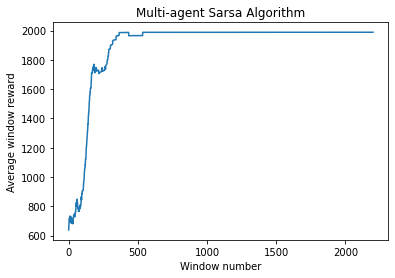

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Multi-agent Sarsa Algorithm');

## Multi-agent Sarsa (slippery)

false action probability = 0.4

In [ ]:
def multi_agent_sarsa(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        if random.uniform(0, 1) > eps:
            a1 = np.argmax(np.max(Q_table_1[s,:,:], axis=1))
            if random.uniform(0,1) > 0.6:
                a1 = random.choice(all_actions)             

        else:
            a1 = random.choice(all_actions)
            
        if random.uniform(0, 1) > eps:
            a2 = np.argmax(np.max(Q_table_2[s,:,:], axis=0))
            if random.uniform(0,1) > 0.6:
                a2 = random.choice(all_actions)         
        
        else:
            a2 = random.choice(all_actions)
            
        all_rewards = 0
        step = 0
        while True:
            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            s_prime = state_dict[s1_prime + s2_prime]
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
                
            if random.uniform(0, 1) > eps:
                a1_prime = np.argmax(np.max(Q_table_1[s_prime,:,:], axis=1))
            else:
                a1_prime = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a2_prime = np.argmax(np.max(Q_table_2[s_prime,:,:], axis=0))
            else:
                a2_prime = random.choice(all_actions)    
                
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            Q_table_1[s,a1,a2] += alpha * (r + gamma * Q_table_1[s_prime,a1_prime,a2_prime] - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * Q_table_2[s_prime,a1_prime,a2_prime] - Q_table_2[s,a1,a2])
            s = s_prime
            a1 = a1_prime
            a2 = a2_prime
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [ ]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = multi_agent_sarsa(env1, env2, 0.99, 0.1, 0.9999, 2200, 2)

8
Congrat
10
Congrat
11
Congrat
13
Congrat
15
Congrat
16
Congrat
17
Congrat
19
Congrat
22
Congrat
29
Congrat
30
Congrat
34
Congrat
40
Congrat
47
Congrat
54
Congrat
57
Congrat
61
Congrat
64
Congrat
65
Congrat
68
Congrat
77
Congrat
79
Congrat
83
Congrat
85
Congrat
91
Congrat
92
Congrat
97
Congrat
99
Congrat
103
Congrat
108
Congrat
112
Congrat
120
Congrat
123
Congrat
126
Congrat
134
Congrat
138
Congrat
141
Congrat
145
Congrat
149
Congrat
150
Congrat
164
Congrat
177
Congrat
190
Congrat
192
Congrat
196
Congrat
200
Congrat
202
Congrat
203
Congrat
206
Congrat
207
Congrat
208
Congrat
212
Congrat
214
Congrat
221
Congrat
235
Congrat
237
Congrat
242
Congrat
245
Congrat
247
Congrat
248
Congrat
252
Congrat
254
Congrat
255
Congrat
256
Congrat
257
Congrat
258
Congrat
261
Congrat
263
Congrat
266
Congrat
272
Congrat
275
Congrat
280
Congrat
282
Congrat
284
Congrat
285
Congrat
286
Congrat
287
Congrat
289
Congrat
290
Congrat
291
Congrat
293
Congrat
294
Congrat
295
Congrat
296
Congrat
297
Congrat
298
Congr

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

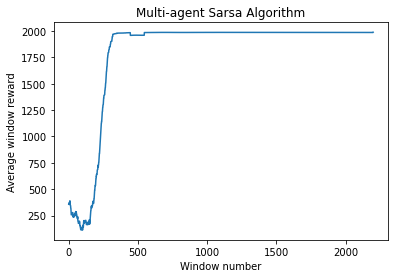

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Multi-agent Sarsa Algorithm');

## Multi-agent Sarsa (slippery)

false action probability = 0.7

In [ ]:
def multi_agent_sarsa(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        if random.uniform(0, 1) > eps:
            a1 = np.argmax(np.max(Q_table_1[s,:,:], axis=1))
            if random.uniform(0,1) > 0.3:
                a1 = random.choice(all_actions)             

        else:
            a1 = random.choice(all_actions)
            
        if random.uniform(0, 1) > eps:
            a2 = np.argmax(np.max(Q_table_2[s,:,:], axis=0))
            if random.uniform(0,1) > 0.3:
                a2 = random.choice(all_actions)         
        
        else:
            a2 = random.choice(all_actions)
            
        all_rewards = 0
        step = 0
        while True:
            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            s_prime = state_dict[s1_prime + s2_prime]
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
                
            if random.uniform(0, 1) > eps:
                a1_prime = np.argmax(np.max(Q_table_1[s_prime,:,:], axis=1))
            else:
                a1_prime = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a2_prime = np.argmax(np.max(Q_table_2[s_prime,:,:], axis=0))
            else:
                a2_prime = random.choice(all_actions)    
                
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            Q_table_1[s,a1,a2] += alpha * (r + gamma * Q_table_1[s_prime,a1_prime,a2_prime] - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * Q_table_2[s_prime,a1_prime,a2_prime] - Q_table_2[s,a1,a2])
            s = s_prime
            a1 = a1_prime
            a2 = a2_prime
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [ ]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = multi_agent_sarsa(env1, env2, 0.99, 0.1, 0.9999, 2200, 2)

7
Congrat
10
Congrat
11
Congrat
13
Congrat
24
Congrat
25
Congrat
30
Congrat
32
Congrat
34
Congrat
35
Congrat
39
Congrat
47
Congrat
49
Congrat
50
Congrat
52
Congrat
55
Congrat
59
Congrat
60
Congrat
61
Congrat
66
Congrat
68
Congrat
71
Congrat
74
Congrat
76
Congrat
77
Congrat
79
Congrat
81
Congrat
89
Congrat
91
Congrat
94
Congrat
96
Congrat
100
Congrat
107
Congrat
111
Congrat
118
Congrat
121
Congrat
125
Congrat
145
Congrat
147
Congrat
148
Congrat
151
Congrat
155
Congrat
157
Congrat
158
Congrat
160
Congrat
161
Congrat
163
Congrat
167
Congrat
168
Congrat
169
Congrat
170
Congrat
171
Congrat
172
Congrat
173
Congrat
174
Congrat
175
Congrat
176
Congrat
177
Congrat
178
Congrat
179
Congrat
180
Congrat
181
Congrat
182
Congrat
183
Congrat
184
Congrat
185
Congrat
186
Congrat
187
Congrat
188
Congrat
189
Congrat
190
Congrat
192
Congrat
193
Congrat
194
Congrat
195
Congrat
196
Congrat
198
Congrat
199
Congrat
200
Congrat
202
Congrat
203
Congrat
204
Congrat
205
Congrat
206
Congrat
208
Congrat
209
Congrat


In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

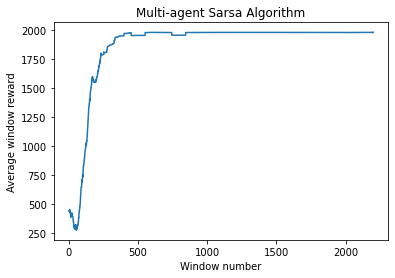

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Multi-agent Sarsa Algorithm');

## Friend Algorithm

In [31]:
def friend_q_learning(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                a1 = np.argmax(np.max(Q_table_1[s,:,:], axis=1))
            else:
                a1 = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a2 = np.argmax(np.max(Q_table_2[s,:,:], axis=0))
            else:
                a2 = random.choice(all_actions)

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            Q_table_1[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_1[next_state,:,:], axis=1)) - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_2[next_state,:,:], axis=0)) - Q_table_2[s,a1,a2])
            s = next_state
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [32]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = friend_q_learning(env1, env2, 0.99, 0.1, 0.999, 2000, 2)

4
Congrat
7
Congrat
12
Congrat
16
Congrat
23
Congrat
29
Congrat
32
Congrat
33
Congrat
35
Congrat
50
Congrat
53
Congrat
59
Congrat
60
Congrat
61
Congrat
62
Congrat
64
Congrat
65
Congrat
66
Congrat
67
Congrat
68
Congrat
70
Congrat
71
Congrat
72
Congrat
73
Congrat
74
Congrat
76
Congrat
77
Congrat
78
Congrat
80
Congrat
81
Congrat
83
Congrat
84
Congrat
85
Congrat
86
Congrat
87
Congrat
88
Congrat
90
Congrat
92
Congrat
93
Congrat
94
Congrat
95
Congrat
96
Congrat
98
Congrat
99
Congrat
100
Congrat
101
Congrat
102
Congrat
104
Congrat
105
Congrat
106
Congrat
108
Congrat
109
Congrat
111
Congrat
112
Congrat
113
Congrat
114
Congrat
115
Congrat
116
Congrat
118
Congrat
119
Congrat
120
Congrat
121
Congrat
122
Congrat
123
Congrat
125
Congrat
126
Congrat
127
Congrat
128
Congrat
129
Congrat
130
Congrat
131
Congrat
132
Congrat
133
Congrat
134
Congrat
135
Congrat
136
Congrat
137
Congrat
138
Congrat
139
Congrat
140
Congrat
141
Congrat
142
Congrat
143
Congrat
145
Congrat
146
Congrat
147
Congrat
148
Congrat
14

783
Congrat
784
Congrat
785
Congrat
786
Congrat
787
Congrat
788
Congrat
789
Congrat
790
Congrat
791
Congrat
792
Congrat
793
Congrat
794
Congrat
795
Congrat
796
Congrat
797
Congrat
798
Congrat
799
Congrat
800
Congrat
801
Congrat
802
Congrat
803
Congrat
804
Congrat
805
Congrat
806
Congrat
807
Congrat
808
Congrat
809
Congrat
810
Congrat
811
Congrat
812
Congrat
813
Congrat
814
Congrat
815
Congrat
816
Congrat
817
Congrat
818
Congrat
819
Congrat
820
Congrat
821
Congrat
822
Congrat
823
Congrat
824
Congrat
825
Congrat
826
Congrat
827
Congrat
828
Congrat
829
Congrat
830
Congrat
831
Congrat
832
Congrat
833
Congrat
834
Congrat
835
Congrat
836
Congrat
837
Congrat
838
Congrat
839
Congrat
840
Congrat
841
Congrat
842
Congrat
843
Congrat
844
Congrat
845
Congrat
846
Congrat
847
Congrat
848
Congrat
849
Congrat
850
Congrat
851
Congrat
852
Congrat
853
Congrat
854
Congrat
855
Congrat
856
Congrat
857
Congrat
858
Congrat
859
Congrat
860
Congrat
861
Congrat
862
Congrat
863
Congrat
864
Congrat
865
Congrat
866


1554
Congrat
1555
Congrat
1556
Congrat
1557
Congrat
1558
Congrat
1559
Congrat
1560
Congrat
1561
Congrat
1562
Congrat
1563
Congrat
1564
Congrat
1565
Congrat
1566
Congrat
1567
Congrat
1568
Congrat
1569
Congrat
1570
Congrat
1571
Congrat
1572
Congrat
1573
Congrat
1574
Congrat
1575
Congrat
1576
Congrat
1577
Congrat
1578
Congrat
1579
Congrat
1580
Congrat
1581
Congrat
1582
Congrat
1583
Congrat
1584
Congrat
1585
Congrat
1586
Congrat
1587
Congrat
1588
Congrat
1589
Congrat
1590
Congrat
1591
Congrat
1592
Congrat
1593
Congrat
1594
Congrat
1595
Congrat
1596
Congrat
1597
Congrat
1598
Congrat
1599
Congrat
1600
Congrat
1601
Congrat
1602
Congrat
1603
Congrat
1604
Congrat
1605
Congrat
1606
Congrat
1607
Congrat
1608
Congrat
1609
Congrat
1610
Congrat
1611
Congrat
1612
Congrat
1613
Congrat
1614
Congrat
1615
Congrat
1616
Congrat
1617
Congrat
1618
Congrat
1619
Congrat
1620
Congrat
1621
Congrat
1622
Congrat
1623
Congrat
1624
Congrat
1625
Congrat
1626
Congrat
1627
Congrat
1628
Congrat
1629
Congrat
1630
Congrat

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

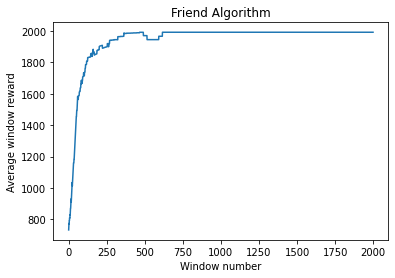

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Friend Algorithm

gamma = 0.1

In [33]:
hist = friend_q_learning(env1, env2, 0.99, 0.1, 0.1, 2000, 2)

4
Congrat
17
Congrat
19
Congrat
20
Congrat
21
Congrat
22
Congrat
23
Congrat
25
Congrat
26
Congrat
30
Congrat
32
Congrat
34
Congrat
35
Congrat
36
Congrat
37
Congrat
41
Congrat
43
Congrat
48
Congrat
51
Congrat
52
Congrat
55
Congrat
58
Congrat
60
Congrat
61
Congrat
62
Congrat
64
Congrat
65
Congrat
66
Congrat
67
Congrat
68
Congrat
69
Congrat
70
Congrat
71
Congrat
72
Congrat
73
Congrat
78
Congrat
79
Congrat
80
Congrat
82
Congrat
83
Congrat
85
Congrat
91
Congrat
93
Congrat
94
Congrat
96
Congrat
103
Congrat
108
Congrat
109
Congrat
110
Congrat
111
Congrat
112
Congrat
138
Congrat
141
Congrat
152
Congrat
159
Congrat
160
Congrat
162
Congrat
165
Congrat
166
Congrat
167
Congrat
168
Congrat
169
Congrat
170
Congrat
171
Congrat
173
Congrat
179
Congrat
180
Congrat
181
Congrat
184
Congrat
185
Congrat
186
Congrat
188
Congrat
189
Congrat
191
Congrat
193
Congrat
194
Congrat
195
Congrat
196
Congrat
197
Congrat
198
Congrat
201
Congrat
205
Congrat
210
Congrat
211
Congrat
212
Congrat
213
Congrat
216
Congrat
21

In [34]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

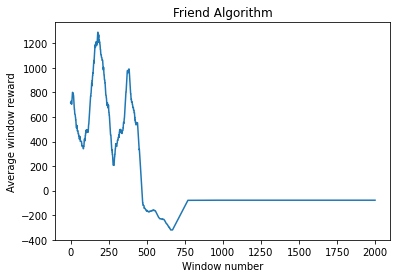

In [35]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Friend Algorithm

gamma = 0.4

In [36]:
hist = friend_q_learning(env1, env2, 0.99, 0.1, 0.4, 2000, 2)

8
Congrat
9
Congrat
11
Congrat
15
Congrat
22
Congrat
30
Congrat
39
Congrat
41
Congrat
42
Congrat
44
Congrat
48
Congrat
53
Congrat
54
Congrat
55
Congrat
57
Congrat
60
Congrat
61
Congrat
63
Congrat
64
Congrat
65
Congrat
66
Congrat
67
Congrat
69
Congrat
71
Congrat
72
Congrat
73
Congrat
76
Congrat
77
Congrat
81
Congrat
82
Congrat
84
Congrat
86
Congrat
87
Congrat
88
Congrat
90
Congrat
94
Congrat
95
Congrat
97
Congrat
98
Congrat
100
Congrat
104
Congrat
107
Congrat
108
Congrat
109
Congrat
110
Congrat
111
Congrat
112
Congrat
114
Congrat
115
Congrat
116
Congrat
120
Congrat
121
Congrat
125
Congrat
127
Congrat
128
Congrat
129
Congrat
133
Congrat
135
Congrat
139
Congrat
140
Congrat
141
Congrat
142
Congrat
143
Congrat
144
Congrat
145
Congrat
146
Congrat
147
Congrat
149
Congrat
150
Congrat
152
Congrat
154
Congrat
155
Congrat
156
Congrat
157
Congrat
158
Congrat
159
Congrat
160
Congrat
161
Congrat
162
Congrat
163
Congrat
164
Congrat
165
Congrat
166
Congrat
168
Congrat
169
Congrat
171
Congrat
172
Congr

In [37]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

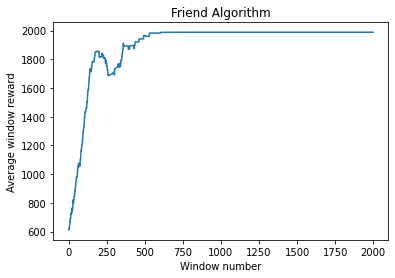

In [38]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Friend Algorithm

gamma = 0.9

In [39]:
hist = friend_q_learning(env1, env2, 0.99, 0.1, 0.9, 2000, 2)

1
Congrat
7
Congrat
11
Congrat
18
Congrat
19
Congrat
24
Congrat
27
Congrat
28
Congrat
29
Congrat
30
Congrat
34
Congrat
36
Congrat
38
Congrat
45
Congrat
48
Congrat
49
Congrat
50
Congrat
52
Congrat
53
Congrat
55
Congrat
57
Congrat
58
Congrat
59
Congrat
60
Congrat
62
Congrat
63
Congrat
64
Congrat
65
Congrat
66
Congrat
68
Congrat
73
Congrat
76
Congrat
80
Congrat
81
Congrat
83
Congrat
89
Congrat
91
Congrat
93
Congrat
94
Congrat
96
Congrat
97
Congrat
98
Congrat
100
Congrat
101
Congrat
102
Congrat
103
Congrat
104
Congrat
106
Congrat
108
Congrat
110
Congrat
111
Congrat
112
Congrat
113
Congrat
114
Congrat
115
Congrat
116
Congrat
117
Congrat
118
Congrat
119
Congrat
120
Congrat
121
Congrat
122
Congrat
123
Congrat
124
Congrat
125
Congrat
128
Congrat
129
Congrat
130
Congrat
131
Congrat
132
Congrat
134
Congrat
135
Congrat
136
Congrat
137
Congrat
138
Congrat
139
Congrat
140
Congrat
142
Congrat
143
Congrat
144
Congrat
146
Congrat
147
Congrat
148
Congrat
149
Congrat
150
Congrat
151
Congrat
152
Congrat


In [40]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

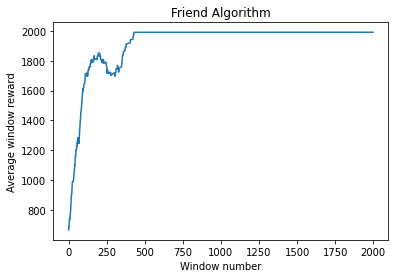

In [41]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Friend Algorithm (slippery)

false action probablity = 0.1

In [11]:
def friend_q_learning(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                a1 = np.argmax(np.max(Q_table_1[s,:,:], axis=1))
                if random.uniform(0,1) > 0.9:
                    a1 = random.choice(all_actions)
            else:
                a1 = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a2 = np.argmax(np.max(Q_table_2[s,:,:], axis=0))
                if random.uniform(0,1) > 0.9:
                    a2 = random.choice(all_actions)
            else:
                a2 = random.choice(all_actions)

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            Q_table_1[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_1[next_state,:,:], axis=1)) - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_2[next_state,:,:], axis=0)) - Q_table_2[s,a1,a2])
            s = next_state
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [12]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = friend_q_learning(env1, env2, 0.99, 0.1, 0.999, 2000, 2)

2
Congrat
4
Congrat
11
Congrat
13
Congrat
14
Congrat
17
Congrat
20
Congrat
27
Congrat
30
Congrat
31
Congrat
33
Congrat
36
Congrat
41
Congrat
44
Congrat
47
Congrat
48
Congrat
53
Congrat
55
Congrat
58
Congrat
59
Congrat
63
Congrat
65
Congrat
66
Congrat
69
Congrat
72
Congrat
74
Congrat
75
Congrat
77
Congrat
78
Congrat
80
Congrat
81
Congrat
82
Congrat
83
Congrat
84
Congrat
87
Congrat
89
Congrat
90
Congrat
97
Congrat
98
Congrat
102
Congrat
103
Congrat
104
Congrat
105
Congrat
106
Congrat
107
Congrat
108
Congrat
109
Congrat
110
Congrat
111
Congrat
112
Congrat
113
Congrat
115
Congrat
116
Congrat
117
Congrat
119
Congrat
121
Congrat
123
Congrat
124
Congrat
125
Congrat
126
Congrat
127
Congrat
128
Congrat
129
Congrat
131
Congrat
132
Congrat
133
Congrat
134
Congrat
135
Congrat
136
Congrat
138
Congrat
139
Congrat
141
Congrat
142
Congrat
143
Congrat
144
Congrat
145
Congrat
146
Congrat
147
Congrat
148
Congrat
149
Congrat
150
Congrat
151
Congrat
152
Congrat
153
Congrat
154
Congrat
156
Congrat
157
Congr

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

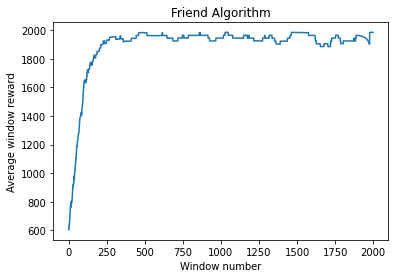

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Friend Algorithm (slippery)

false action probablity = 0.4

In [13]:
def friend_q_learning(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                a1 = np.argmax(np.max(Q_table_1[s,:,:], axis=1))
                if random.uniform(0,1) > 0.6:
                    a1 = random.choice(all_actions)
            else:
                a1 = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a2 = np.argmax(np.max(Q_table_2[s,:,:], axis=0))
                if random.uniform(0,1) > 0.6:
                    a2 = random.choice(all_actions)
            else:
                a2 = random.choice(all_actions)

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            Q_table_1[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_1[next_state,:,:], axis=1)) - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_2[next_state,:,:], axis=0)) - Q_table_2[s,a1,a2])
            s = next_state
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [14]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = friend_q_learning(env1, env2, 0.99, 0.1, 0.999, 2000, 2)

15
Congrat
23
Congrat
25
Congrat
42
Congrat
45
Congrat
46
Congrat
51
Congrat
56
Congrat
57
Congrat
59
Congrat
60
Congrat
61
Congrat
64
Congrat
67
Congrat
73
Congrat
74
Congrat
75
Congrat
76
Congrat
78
Congrat
81
Congrat
84
Congrat
87
Congrat
88
Congrat
89
Congrat
91
Congrat
92
Congrat
93
Congrat
94
Congrat
95
Congrat
96
Congrat
97
Congrat
99
Congrat
100
Congrat
103
Congrat
104
Congrat
105
Congrat
107
Congrat
108
Congrat
109
Congrat
113
Congrat
114
Congrat
118
Congrat
119
Congrat
120
Congrat
122
Congrat
124
Congrat
125
Congrat
127
Congrat
129
Congrat
130
Congrat
131
Congrat
133
Congrat
134
Congrat
135
Congrat
137
Congrat
139
Congrat
141
Congrat
142
Congrat
144
Congrat
147
Congrat
148
Congrat
150
Congrat
151
Congrat
152
Congrat
153
Congrat
154
Congrat
155
Congrat
156
Congrat
158
Congrat
160
Congrat
161
Congrat
162
Congrat
163
Congrat
164
Congrat
165
Congrat
166
Congrat
167
Congrat
168
Congrat
170
Congrat
171
Congrat
172
Congrat
173
Congrat
175
Congrat
176
Congrat
178
Congrat
179
Congrat


In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

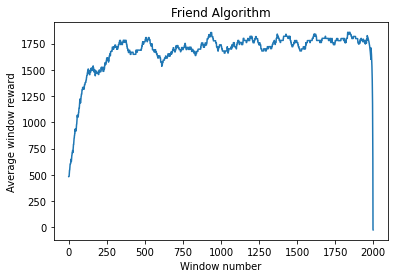

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Friend Algorithm (slippery)

false action probablity = 0.7

In [15]:
def friend_q_learning(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                a1 = np.argmax(np.max(Q_table_1[s,:,:], axis=1))
                if random.uniform(0,1) > 0.3:
                    a1 = random.choice(all_actions)
            else:
                a1 = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a2 = np.argmax(np.max(Q_table_2[s,:,:], axis=0))
                if random.uniform(0,1) > 0.3:
                    a2 = random.choice(all_actions)
            else:
                a2 = random.choice(all_actions)

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            Q_table_1[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_1[next_state,:,:], axis=1)) - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_2[next_state,:,:], axis=0)) - Q_table_2[s,a1,a2])
            s = next_state
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [16]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
hist = friend_q_learning(env1, env2, 0.99, 0.1, 0.999, 2000, 2)

10
Congrat
11
Congrat
13
Congrat
14
Congrat
15
Congrat
17
Congrat
21
Congrat
23
Congrat
24
Congrat
26
Congrat
27
Congrat
30
Congrat
33
Congrat
39
Congrat
42
Congrat
45
Congrat
48
Congrat
49
Congrat
51
Congrat
57
Congrat
59
Congrat
60
Congrat
62
Congrat
64
Congrat
66
Congrat
67
Congrat
70
Congrat
75
Congrat
81
Congrat
82
Congrat
85
Congrat
87
Congrat
88
Congrat
92
Congrat
98
Congrat
99
Congrat
101
Congrat
102
Congrat
104
Congrat
107
Congrat
109
Congrat
110
Congrat
111
Congrat
112
Congrat
119
Congrat
120
Congrat
121
Congrat
123
Congrat
124
Congrat
127
Congrat
130
Congrat
131
Congrat
142
Congrat
143
Congrat
144
Congrat
146
Congrat
148
Congrat
149
Congrat
150
Congrat
151
Congrat
152
Congrat
154
Congrat
155
Congrat
158
Congrat
159
Congrat
166
Congrat
167
Congrat
168
Congrat
169
Congrat
171
Congrat
175
Congrat
178
Congrat
179
Congrat
180
Congrat
181
Congrat
182
Congrat
183
Congrat
184
Congrat
186
Congrat
187
Congrat
189
Congrat
190
Congrat
192
Congrat
199
Congrat
200
Congrat
207
Congrat
208


In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

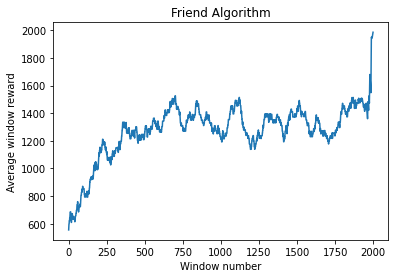

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

# Foe algorithm

In [17]:
def foe_q_learning(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                a21 = np.argmin(np.min(Q_table_1[s,:,:], axis=0))
                a1 = np.argmax(np.max(Q_table_1[s,:,a21]))
            else:
                a1 = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a22 = np.argmin(np.min(Q_table_2[s,:,:], axis=1))
                a2 = np.argmax(np.max(Q_table_1[s,a22,:]))

            else:
                a2 = random.choice(all_actions)

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            Q_table_1[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_1[next_state,:,:], axis=1)) - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_2[next_state,:,:], axis=0)) - Q_table_2[s,a1,a2])
            s = next_state
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [18]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [19]:
hist = foe_q_learning(env1, env2, 0.99, 0.1, 0.999, 750, 2)

3
Congrat
9
Congrat
11
Congrat
13
Congrat
17
Congrat
18
Congrat
19
Congrat
22
Congrat
24
Congrat
25
Congrat
27
Congrat
28
Congrat
30
Congrat
37
Congrat
39
Congrat
40
Congrat
44
Congrat
48
Congrat
55
Congrat
61
Congrat
67
Congrat
68
Congrat
75
Congrat
83
Congrat
84
Congrat
86
Congrat
87
Congrat
89
Congrat
90
Congrat
93
Congrat
101
Congrat
102
Congrat
112
Congrat
116
Congrat
118
Congrat
134
Congrat
139
Congrat
155
Congrat
158
Congrat
169
Congrat
181
Congrat


In [20]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

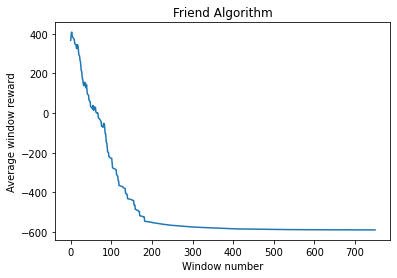

In [21]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Foe algorithm (slippery)

false action probability = 0.1

In [22]:
def foe_q_learning(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                a21 = np.argmin(np.min(Q_table_1[s,:,:], axis=0))
                a1 = np.argmax(np.max(Q_table_1[s,:,a21]))
                if random.uniform(0,1) > 0.9:
                    a1 = random.choice(all_actions)
            else:
                a1 = random.choice(all_actions)
                if random.uniform(0,1) < 0.9:
                    a2 = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a22 = np.argmin(np.min(Q_table_2[s,:,:], axis=1))
                a2 = np.argmax(np.max(Q_table_1[s,a22,:]))

            else:
                a2 = random.choice(all_actions)

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            Q_table_1[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_1[next_state,:,:], axis=1)) - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_2[next_state,:,:], axis=0)) - Q_table_2[s,a1,a2])
            s = next_state
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [23]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [24]:
hist = foe_q_learning(env1, env2, 0.99, 0.1, 0.999, 750, 2)

0
Congrat
13
Congrat
14
Congrat
16
Congrat
24
Congrat
34
Congrat
37
Congrat
42
Congrat
47
Congrat
49
Congrat
53
Congrat
55
Congrat
59
Congrat
60
Congrat
64
Congrat
65
Congrat
68
Congrat
70
Congrat
72
Congrat
75
Congrat
78
Congrat
79
Congrat
93
Congrat
94
Congrat
95
Congrat
98
Congrat
99
Congrat
108
Congrat
112
Congrat
135
Congrat
142
Congrat
167
Congrat
175
Congrat
187
Congrat
213
Congrat
215
Congrat
230
Congrat
245
Congrat
280
Congrat
307
Congrat
311
Congrat
415
Congrat
486
Congrat
677
Congrat


In [25]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

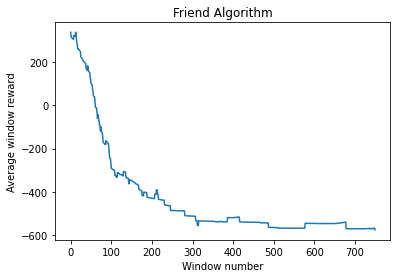

In [26]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Foe algorithm (slippery)

false action probability = 0.4

In [27]:
def foe_q_learning(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                a21 = np.argmin(np.min(Q_table_1[s,:,:], axis=0))
                a1 = np.argmax(np.max(Q_table_1[s,:,a21]))
                if random.uniform(0,1) > 0.6:
                    a1 = random.choice(all_actions)
            else:
                a1 = random.choice(all_actions)
                if random.uniform(0,1) < 0.6:
                    a2 = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a22 = np.argmin(np.min(Q_table_2[s,:,:], axis=1))
                a2 = np.argmax(np.max(Q_table_1[s,a22,:]))

            else:
                a2 = random.choice(all_actions)

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            Q_table_1[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_1[next_state,:,:], axis=1)) - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_2[next_state,:,:], axis=0)) - Q_table_2[s,a1,a2])
            s = next_state
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [28]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [29]:
hist = foe_q_learning(env1, env2, 0.99, 0.1, 0.999, 750, 2)

0
Congrat
11
Congrat
14
Congrat
18
Congrat
19
Congrat
20
Congrat
28
Congrat
29
Congrat
30
Congrat
34
Congrat
36
Congrat
37
Congrat
40
Congrat
45
Congrat
46
Congrat
51
Congrat
61
Congrat
66
Congrat
67
Congrat
69
Congrat
70
Congrat
71
Congrat
72
Congrat
73
Congrat
79
Congrat
92
Congrat
95
Congrat
96
Congrat
99
Congrat
100
Congrat
105
Congrat
109
Congrat
110
Congrat
111
Congrat
116
Congrat
119
Congrat
123
Congrat
128
Congrat
134
Congrat
138
Congrat
152
Congrat
153
Congrat
154
Congrat
155
Congrat
157
Congrat
162
Congrat
164
Congrat
167
Congrat
171
Congrat
174
Congrat
179
Congrat
183
Congrat
185
Congrat
192
Congrat
197
Congrat
201
Congrat
207
Congrat
209
Congrat
212
Congrat
222
Congrat
224
Congrat
225
Congrat
226
Congrat
227
Congrat
243
Congrat
247
Congrat
250
Congrat
259
Congrat
264
Congrat
272
Congrat
274
Congrat
276
Congrat
277
Congrat
297
Congrat
302
Congrat
309
Congrat
315
Congrat
317
Congrat
349
Congrat
362
Congrat
381
Congrat
384
Congrat
390
Congrat
393
Congrat
407
Congrat
413
Congra

In [30]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

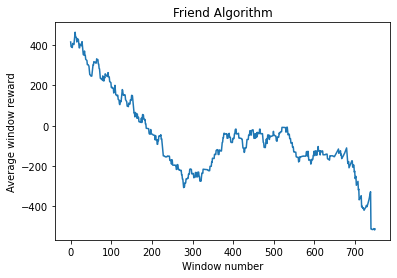

In [31]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Foe algorithm (slippery)

false action probability = 0.7

In [32]:
def foe_q_learning(env1, env2, eps, alpha, gamma, n_episodes, n_agents):
    all_states = env1.get_all_states()
    all_actions = env1.get_all_actions()
    state_dict, goal_states = state_map(n_agents, all_states, env1.win_state)
    shape_list = [len(state_dict)]
    for i in range (n_agents):
        shape_list.append(len(all_actions)) 
        
        
    Q_table_1 = np.zeros(tuple(shape_list))
    Q_table_2 = np.zeros(tuple(shape_list))
#     for state_num in range(len(state_dict)):
#         for a1 in all_actions:
#             for a2 in all_actions:
#                 if state_num not in goal_states:
#                     Q_table_1[state_num, a1, a2] =  np.random.normal()
#                     Q_table_2[state_num, a1, a2] =  np.random.normal()

                
    rewards_hist = []            
    for episode in range(n_episodes):
        
        s1 = env1.reset()
        s2 = env2.reset()
        s = state_dict[s1 + s2]
        all_rewards = 0
        step = 0
        while True:
            if random.uniform(0, 1) > eps:
                a21 = np.argmin(np.min(Q_table_1[s,:,:], axis=0))
                a1 = np.argmax(np.max(Q_table_1[s,:,a21]))
                if random.uniform(0,1) > 0.3:
                    a1 = random.choice(all_actions)
            else:
                a1 = random.choice(all_actions)
                if random.uniform(0,1) < 0.3:
                    a2 = random.choice(all_actions)
            
            if random.uniform(0, 1) > eps:
                a22 = np.argmin(np.min(Q_table_2[s,:,:], axis=1))
                a2 = np.argmax(np.max(Q_table_1[s,a22,:]))

            else:
                a2 = random.choice(all_actions)

            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
            step += 1
            all_rewards += r1 + r2
            r = r1 + r2
#             r = max(r1 , r2)
            next_state = state_dict[s1_prime + s2_prime]
            Q_table_1[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_1[next_state,:,:], axis=1)) - Q_table_1[s,a1,a2])
            Q_table_2[s,a1,a2] += alpha * (r + gamma * np.max(np.max(Q_table_2[next_state,:,:], axis=0)) - Q_table_2[s,a1,a2])
            s = next_state
#             if done1 and s not in goal_states:
#                 s1 = env1.reset()
#                 s = state_dict[s1 + s2_prime]
#                 rewards_hist.append(all_rewards)
#             elif done1 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
            
#             if done2 and s not in goal_states:
#                 s2 = env2.reset()
#                 s = state_dict[s1_prime + s2]
#                 rewards_hist.append(all_rewards)
#             elif done2 and s in goal_states:
#                 rewards_hist.append(all_rewards)
#                 break
#             if step >= 300:
#                 rewards_hist.append(all_rewards)
#                 print(all_rewards)
#                 break
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
                
        eps *= 0.99       
                
    return rewards_hist             

In [33]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [34]:
hist = foe_q_learning(env1, env2, 0.99, 0.1, 0.999, 750, 2)

12
Congrat
22
Congrat
23
Congrat
25
Congrat
30
Congrat
35
Congrat
36
Congrat
41
Congrat
44
Congrat
45
Congrat
47
Congrat
48
Congrat
58
Congrat
59
Congrat
61
Congrat
68
Congrat
69
Congrat
71
Congrat
72
Congrat
74
Congrat
76
Congrat
81
Congrat
85
Congrat
87
Congrat
88
Congrat
90
Congrat
91
Congrat
92
Congrat
106
Congrat
107
Congrat
111
Congrat
116
Congrat
130
Congrat
132
Congrat
135
Congrat
148
Congrat
153
Congrat
159
Congrat
160
Congrat
162
Congrat
167
Congrat
174
Congrat
183
Congrat
184
Congrat
196
Congrat
199
Congrat
200
Congrat
202
Congrat
207
Congrat
208
Congrat
210
Congrat
214
Congrat
215
Congrat
223
Congrat
228
Congrat
229
Congrat
232
Congrat
241
Congrat
243
Congrat
252
Congrat
256
Congrat
269
Congrat
276
Congrat
280
Congrat
282
Congrat
283
Congrat
291
Congrat
294
Congrat
297
Congrat
298
Congrat
304
Congrat
305
Congrat
306
Congrat
307
Congrat
319
Congrat
347
Congrat
348
Congrat
354
Congrat
358
Congrat
364
Congrat
367
Congrat
372
Congrat
376
Congrat
380
Congrat
382
Congrat
386
Cong

In [35]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

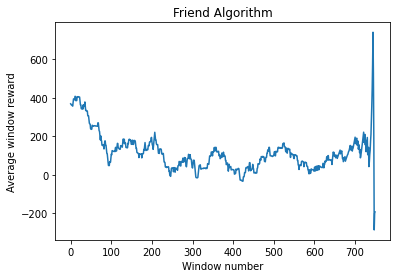

In [36]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Friend Algorithm');

## Networked actor-crtic

In [42]:
def policy(func_approx, s, all_actions, theta):
    nums = []
    for a in all_actions:
        a_code = action_map(a)
        coding = np.zeros((len(func_approx), 1))
        ind = 0
        for func in func_approx:
            coding[ind,0] = func.pdf([s[0],s[1],a_code[0],a_code[1]])
            ind += 1 
            
        nums.append(np.exp(coding.T @ theta))
        
    policy_prob = []
    for num in nums:
        policy_prob.append(float(num / sum(nums)))
#     print(policy_prob)    
    return policy_prob  

In [43]:
def compute_Q(func_approx, s, a1, a2, w):
    a1_code = action_map(a1)
    a2_code = action_map(a2)
    coding = np.zeros((len(func_approx), 1))
    ind = 0
    for func in func_approx:
        coding[ind,0] = func.pdf([s[0],s[1],a1_code[0],a1_code[1], a2_code[0],a2_code[1]])
        ind += 1 
        
    return coding.T @ w, coding  

In [44]:
def policy_derivative(func_approx, s, a, all_actions, theta):
    a_code = action_map(a)
    phi_s_ai = np.zeros((len(func_approx), 1))
    ind = 0
    for func in func_approx:
        phi_s_ai[ind, 0] = func.pdf([s[0],s[1],a_code[0],a_code[1]])
        ind += 1
        
    all_phis = []
    for action in all_actions:
        a_code = action_map(action)
        temp = np.zeros((len(func_approx), 1))
        ind = 0
        for func in func_approx: 
            temp[ind, 0] = func.pdf([s[0],s[1],a_code[0],a_code[1]])
            ind += 1
        all_phis.append(temp)    
        
    num = np.zeros((len(func_approx), 1))
    den = 0
    for phi in all_phis:
        num += phi * np.exp(phi.T @ theta)
        den += np.exp(phi.T @ theta)
        
    return phi_s_ai - num / den  

In [45]:
def multi_actor_critc(env1, env2, n_components, mu_pol, sigma_pol, mu_Q, sigma_Q, n_episodes):
    u1, u2 = -0.2, -0.2
    
    beta = 0.1
    all_actions = env1.get_all_actions()
    
    mean = np.zeros(n_components)
    cov = np.eye(n_components)
    w1, w2 = np.random.multivariate_normal(mean, cov), np.random.multivariate_normal(mean, cov)
    w1_tilda, w2_tilda = np.random.multivariate_normal(mean, cov), np.random.multivariate_normal(mean, cov)
    theta1, theta2 = np.random.multivariate_normal(mean, cov), np.random.multivariate_normal(mean, cov)
    
    func_approx_pol = []
    for i in range(n_components):
        func_approx_pol.append(multivariate_normal(mean=mu_pol[i], cov=sigma_pol[i]))
        
    func_approx_Q = []
    for i in range(n_components):
        func_approx_Q.append(multivariate_normal(mean=mu_Q[i], cov=sigma_Q[i]))    
        

    for episode in range (n_episodes):
        s1 = env1.reset()
        s2 = env2.reset()
#         s = state_dict[s1 + s2]
        a1 = int(np.random.choice(all_actions, p=policy(func_approx_pol, s1 + s2, all_actions, theta1)))
        a2 = int(np.random.choice(all_actions, p=policy(func_approx_pol, s1 + s2, all_actions, theta2)))
        all_rewards = 0
        step = 0
        while True:
            s1_prime, r1, done1 = env1.step(a1)
            s2_prime, r2, done2 = env2.step(a2)
            step += 1
            if s1_prime == env1.win_state or s2_prime == env2.win_state:
                print(episode)
                print('Congrat')
                
#             next_state = state_dict[s1_prime + s2_prime]
            u1_new = (1-beta)*u1 + beta*r1
            u2_new = (1-beta)*u2 + beta*r2
            a1_new = int(np.random.choice(all_actions, p=policy(func_approx_pol, s1_prime + s2_prime, all_actions, theta1)))
            a2_new = int(np.random.choice(all_actions, p=policy(func_approx_pol, s1_prime + s2_prime, all_actions, theta2)))
            
            Q1, phi1 = compute_Q(func_approx_Q, s1 + s2, a1, a2, w1)
            Q2, phi2 = compute_Q(func_approx_Q, s1 + s2, a1, a2, w2)
            
            Q1_new, _ = compute_Q(func_approx_Q, s1_prime + s2_prime, a1_new, a2_new, w1)
            Q2_new, _ = compute_Q(func_approx_Q, s1_prime + s2_prime, a1_new, a2_new, w2)
           
            
            delta1 = r1 - u1 + Q1_new - Q1
            delta2 = r2 - u2 + Q2_new - Q2
            
            
            w1_tilda  = w1 + (beta * delta1 * phi1).squeeze(-1)
            w2_tilda  = w2 + (beta * delta2 * phi2).squeeze(-1)
            
            temp = 0
            p=policy(func_approx_pol, s1 + s2, all_actions, theta1)
            ind = 0
            for Action in all_actions:
                temp_phi, _  = compute_Q(func_approx_Q, s1 + s2, Action, a2, w1) 
                temp += temp_phi * p[ind]
                ind += 1
                
            A1 = Q1 - temp
            
            psi1 = policy_derivative(func_approx_pol, s1 + s2, a1, all_actions, theta1)

            theta1 += beta * A1 * psi1.squeeze(-1)
            
            temp = 0
            p=policy(func_approx_pol, s1 + s2, all_actions, theta2)
            ind = 0
            for Action in all_actions:
                temp_phi, _  = compute_Q(func_approx_Q, s1 + s2, a1, Action, w2) 
                temp += temp_phi * p[ind]
                ind += 1
                
            A2 = Q2 - temp
            psi2 = policy_derivative(func_approx_pol, s1 + s2, a2, all_actions, theta2)
            theta2 += beta * A2 * psi2.squeeze(-1)
            

            w1 = (w1_tilda + w2_tilda) / 2
            w2 = (w1_tilda + w2_tilda) / 2
            
            u1 = u1_new
            u2 = u2_new
            
            a1 = a1_new
            a2 = a2_new
            
            s1 = s1_prime
            s2 = s2_prime 
            
            if done1 or done2 or step >= 300:
                rewards_hist.append(all_rewards)
#                 print(all_rewards)
                break
    
    return rewards_hist
            

In [46]:
env1 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)
env2 = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [ ]:
mu_pol = [np.array([1,4,0.5,0]), np.array([3,4,-0.5,0]), 
      np.array([5,4,0,0.5]), np.array([7,4,0,-0.5])]
sigma_pol = [np.eye(4), np.eye(4), 0.01*np.eye(4), 0.01*np.eye(4)]

mu_Q = [np.array([1,4,0.5,0,0.5,0]), np.array([3,4,-0.5,0,-0.5,0]), 
      np.array([5,4,0,0.5, 0,0.5]), np.array([7,4,0,-0.5, 0,-0.5])]
sigma_Q = [np.eye(6), np.eye(6), 0.01*np.eye(6), 0.01*np.eye(6)]


hist = multi_actor_critc(env1, env2, 4, mu_pol, sigma_pol, mu_Q, sigma_Q, 1000)

0
Congrat
33
Congrat
38
Congrat
39
Congrat
41
Congrat
64
Congrat
66
Congrat
68
Congrat
74
Congrat
79
Congrat
80
Congrat
82
Congrat
83
Congrat
84
Congrat
85
Congrat
89
Congrat
91
Congrat
98
Congrat
107
Congrat
110
Congrat
114
Congrat
117
Congrat
119
Congrat
124
Congrat
136
Congrat
138
Congrat
141
Congrat
143
Congrat
144
Congrat
148
Congrat
150
Congrat
152
Congrat
163
Congrat
186
Congrat
188
Congrat
191
Congrat
196
Congrat
198
Congrat
199
Congrat
201
Congrat
203
Congrat
213
Congrat
214
Congrat
219
Congrat
221
Congrat
222
Congrat
227
Congrat
228
Congrat
230
Congrat
231
Congrat
237
Congrat
243
Congrat
245
Congrat
254
Congrat
256
Congrat
260
Congrat
266
Congrat
270
Congrat
283
Congrat
284
Congrat
286
Congrat
289
Congrat
294
Congrat
298
Congrat
307
Congrat
312
Congrat
325
Congrat
326
Congrat
331
Congrat
338
Congrat
355
Congrat
366
Congrat
367
Congrat
369
Congrat
379
Congrat
380
Congrat
387
Congrat
396
Congrat
409
Congrat
410
Congrat
418
Congrat
420
Congrat
429
Congrat
433
Congrat
435
Congrat

In [ ]:
window = []
for i in range (len(hist)):
    window.append(sum(hist[i:i+101]) / len(hist[i:i+101]))

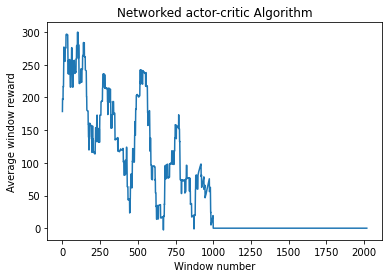

In [ ]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('Networked actor-critic Algorithm');